In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import librosa
import soundfile as sf
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Real-time optimized configuration for SUBESCO
class SUBESCOConfig:
    # Audio parameters optimized for real-time
    SAMPLE_RATE = 22050  # Reduced from 48000 for speed
    TARGET_LENGTH = 3    # Reduced from 5 seconds
    TRIM_THRESHOLD = 25  # Slightly reduced
    MAX_AMPLITUDE = 0.9
    
    # Feature parameters optimized for real-time
    N_MFCC = 13         
    N_MELS = 128          
    N_FRAMES = 500      
    
    NUM_CLASSES = 8
    EMOTIONS = ['Neutral', 'Angry', 'Sad', 'Happy', 'Surprised', 'Fear', 'Disappointment', 'Excitement']
    
    # Training parameters
    BATCH_SIZE = 32 #64
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 5e-4
    NUM_EPOCHS = 60    
    PATIENCE = 25       # Reduced from 50

    # ADD: Enhanced regularization settings
    ENHANCED_DROPOUT = True
    REDUCED_LR = True
    EARLY_STOPPING = True
    
    DEVICE = torch.device('cuda')

config = SUBESCOConfig()

# Create directories
os.makedirs("subesco_augmented", exist_ok=True)
os.makedirs("subesco_processed", exist_ok=True)


d:\Anaconda\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\Anaconda\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
d:\Anaconda\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [16]:
# def load_subesco_dataset(dataset_path):
#     """Load SUBESCO dataset with filename parsing"""
#     paths = []
#     labels = []
    
#     # SUBESCO emotion mapping
#     emotion_map = {
#         'NEUTRAL': 'neutral',
#         'ANGRY': 'angry', 
#         'DISGUST': 'disgust',
#         'FEAR': 'fear',
#         'HAPPY': 'happy',
#         'SAD': 'sad',
#         'SURPRISE': 'surprise'
#     }
    
#     print("Loading SUBESCO dataset...")
    
#     for filename in os.listdir(dataset_path):
#         if filename.endswith('.wav'):
#             try:
#                 # Parse SUBESCO format: Gender_SpeakerNum_SpeakerName_S_SentenceNum_Emotion_Take_RepeatNum.wav
#                 # Example: F_12_TITHI_S_10_SURPRISE_TAKE_5.wav
#                 parts = filename.replace('.wav', '').split('_')
                
#                 if len(parts) >= 7:
#                     emotion_name = parts[5].upper()  # SURPRISE, ANGER, etc.
                    
#                     if emotion_name in emotion_map:
#                         full_path = os.path.join(dataset_path, filename)
#                         paths.append(full_path)
#                         labels.append(emotion_map[emotion_name])
                        
#             except Exception as e:
#                 print(f"Error parsing {filename}: {e}")
#                 continue
    
#     print(f"Loaded {len(paths)} files from SUBESCO")
    
#     # Print distribution
#     label_counts = Counter(labels)
#     print("Original SUBESCO distribution:")
#     for emotion in config.EMOTIONS:
#         emotion_lower = emotion.lower()
#         count = label_counts.get(emotion_lower, 0)
#         print(f"  {emotion}: {count}")
    
#     return paths, labels
# def load_combined_dataset(subesco_path, banglaMOOD_path=None):  # Changed parameter name
#     """
#     Load SUBESCO (all 7 emotions) + BanSpEmo (6 emotions) 
#     Same function signature as your existing function
#     """
    
#     all_paths = []
#     all_labels = []
    
#     # Load SUBESCO dataset (all 7 emotions) - no changes
#     print("Loading SUBESCO dataset (all 7 emotions)...")
#     subesco_paths, subesco_labels = load_subesco_dataset(subesco_path)
#     all_paths.extend(subesco_paths)
#     all_labels.extend(subesco_labels)
    
#     if banglaMOOD_path and os.path.exists(banglaMOOD_path):
#         print("Loading BanglaMOOD dataset...")
#         banglaMOOD_paths, banglaMOOD_labels = load_banglamood_dataset(banglaMOOD_path)  # CHANGED
#         all_paths.extend(banglaMOOD_paths)
#         all_labels.extend(banglaMOOD_labels)
#         print(f"Added {len(banglaMOOD_paths)} BanSpEmo files")
    
#     # Print combined distribution
#     label_counts = Counter(all_labels)
#     print(f"Combined dataset loaded: {len(all_paths)} files")
#     print("Combined distribution:")
#     for emotion in config.EMOTIONS:
#         emotion_lower = emotion.lower()
#         count = label_counts.get(emotion_lower, 0)
#         source = "SUBESCO only" if emotion_lower == 'neutral' else "SUBESCO + BanSpEmo"
#         print(f"  {emotion}: {count} ({source})")
    
#     return all_paths, all_labels

def load_combined_dataset(subesco_path, banglaMOOD_path=None, kbes_path=None):
    """
    Load SUBESCO (all 7 emotions) + BanglaMOOD (6 emotions) + KBES (5 emotions)
    """
    
    all_paths = []
    all_labels = []
    
    # Load SUBESCO dataset (all 7 emotions)
    if subesco_path and os.path.exists(subesco_path):
        print("Loading SUBESCO dataset (all 7 emotions)...")
        subesco_paths, subesco_labels = load_subesco_dataset(subesco_path)
        all_paths.extend(subesco_paths)
        all_labels.extend(subesco_labels)
    
    # Load BanglaMOOD dataset if provided
    if banglaMOOD_path and os.path.exists(banglaMOOD_path):
        print("Loading BanglaMOOD dataset...")
        banglaMOOD_paths, banglaMOOD_labels = load_banglamood_dataset(banglaMOOD_path)
        all_paths.extend(banglaMOOD_paths)
        all_labels.extend(banglaMOOD_labels)
        print(f"Added {len(banglaMOOD_paths)} BanglaMOOD files")
    
    # Load KBES dataset if provided
    if kbes_path and os.path.exists(kbes_path):
        print("Loading KBES dataset...")
        kbes_paths, kbes_labels = load_kbes_dataset(kbes_path)
        all_paths.extend(kbes_paths)
        all_labels.extend(kbes_labels)
        print(f"Added {len(kbes_paths)} KBES files")
    
    # Print combined distribution
    label_counts = Counter(all_labels)
    print(f"Combined dataset loaded: {len(all_paths)} files")
    print("Combined distribution:")
    
    for emotion in config.EMOTIONS:
        emotion_lower = emotion.lower()
        count = label_counts.get(emotion_lower, 0)
        
        # Determine source information
        sources = []
        if emotion_lower in ['neutral', 'angry', 'disappointment', 'fear', 'happy', 'sad', 'surprised']:
            sources.append("SUBESCO")
        if emotion_lower in ['happy', 'sad', 'angry', 'neutral', 'surprised', 'fear', 'excitement', 'disappointment']:
            sources.append("BanglaMOOD")
        if emotion_lower in ['angry', 'disappointment', 'happy', 'neutral', 'sad']:
            sources.append("KBES")
        
        source_info = " + ".join(sources) if sources else "None"
        print(f"  {emotion}: {count} ({source_info})")
    
    return all_paths, all_labels



def load_subesco_dataset(dataset_path):
    """Your existing SUBESCO loader - no changes needed"""
    paths = []
    labels = []
    
    # Keep all 7 SUBESCO emotions
    emotion_map = {
        'NEUTRAL': 'neutral',
        'ANGRY': 'angry', 
        'DISGUST': 'disappointment',    # Keep this
        'FEAR': 'fear',          # Keep this
        'HAPPY': 'happy',
        'SAD': 'sad',
        'SURPRISE': 'surprised'
    }
    
    print("Loading SUBESCO dataset (all 7 emotions)...")
    
    for filename in os.listdir(dataset_path):
        if filename.endswith('.wav'):
            try:
                parts = filename.replace('.wav', '').split('_')
                if len(parts) >= 7:
                    emotion_name = parts[5].upper()
                    
                    if emotion_name in emotion_map:
                        full_path = os.path.join(dataset_path, filename)
                        paths.append(full_path)
                        labels.append(emotion_map[emotion_name])
                        
            except Exception as e:
                continue
    
    return paths, labels

# def load_banspemo_dataset(dataset_path):
#     """Load BanSpEmo dataset with CORRECT 5-component filename parsing"""
#     paths = []
#     labels = []
    
#     # BanSpEmo emotion mapping (same as before)
#     banspemo_emotion_map = {
#         '01': 'angry',     # Anger
#         '02': 'disgust',   # Disgust
#         '03': 'fear',      # Fear
#         '04': 'happy', # Happy
#         '05': 'sad',   # Sad
#         '06': 'surprise'   # Surprised
#     }
    
#     print("Loading BanSpEmo dataset...")
#     found_emotions = Counter()
#     parsed_count = 0
#     total_count = 0
    
#     for filename in os.listdir(dataset_path):
#         if filename.endswith('.wav'):
#             total_count += 1
#             try:
#                 # Parse BanSpEmo ACTUAL 5-component structure
#                 base_name = filename.replace('.wav', '')
#                 parts = base_name.split('_')
                
#                 if len(parts) == 5:  # CORRECTED: 5 components, not 6
#                     sentence_set = parts[0]    # ss1, ss2
#                     sentence_num = parts[1]    # s1, s2, s3...
#                     speaker_number = parts[2]  # sp1, sp2, sp3...
#                     speaker_gender = parts[3]  # m, f
#                     emotion_code = parts[4]    # 01-06
                    
#                     found_emotions[emotion_code] += 1
                    
#                     if emotion_code in banspemo_emotion_map:
#                         full_path = os.path.join(dataset_path, filename)
#                         paths.append(full_path)
#                         labels.append(banspemo_emotion_map[emotion_code])
#                         parsed_count += 1
#                 else:
#                     print(f"Unexpected filename format: {filename} ({len(parts)} parts, expected 5)")
                        
#             except Exception as e:
#                 print(f"Error parsing {filename}: {e}")
#                 continue
    
#     # Debug output
#     print(f"BanSpEmo parsing results:")
#     print(f"  Total WAV files: {total_count}")
#     print(f"  Successfully parsed: {parsed_count}")
#     print(f"  Parse success rate: {parsed_count/total_count*100:.1f}%")
    
#     print("\nEmotion distribution:")
#     for code, count in sorted(found_emotions.items()):
#         emotion_name = banspemo_emotion_map.get(code, "UNKNOWN")
#         print(f"  Code {code} ({emotion_name}): {count} files")
    
#     return paths, labels

def load_banglamood_dataset(dataset_path):
    """Load your BanglaMOOD dataset: EmotionFolder -> AudioFile.wav"""
    paths = []
    labels = []
    
    # BanglaMOOD emotion mapping
    banglamood_emotion_map = {
        'happy': 'happy',
        'sad': 'sad', 
        'angry': 'angry',
        'neutral': 'neutral',
        'surprised': 'surprised',
        'fear': 'fear',
        'excitement': 'excitement',
        'disappointment': 'disappointment'  # Will map to 'disgust' in final processing
    }
    
    print("Loading BanglaMOOD dataset...")
    
    for emotion_dir in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_dir)
        
        if os.path.isdir(emotion_path):
            emotion_name = emotion_dir.lower()
            
            if emotion_name in banglamood_emotion_map:
                # Get all WAV files directly from emotion folder
                for filename in os.listdir(emotion_path):
                    if filename.endswith('.wav'):
                        full_path = os.path.join(emotion_path, filename)
                        paths.append(full_path)
                        labels.append(banglamood_emotion_map[emotion_name])
    
    print(f"Loaded {len(paths)} BanglaMOOD files")
    return paths, labels

def load_kbes_dataset(dataset_path):
    """
    Load KBES dataset: EmotionFolder(High/Low) -> audio.wav files
    """
    paths = []
    labels = []
    
    # KBES emotion mapping (handling intensity levels)
    kbes_emotion_map = {
        'angry (high)': 'angry',
        'angry (low)': 'angry',
        'disgust (high)': 'disappointment',  # Map to disappointment like SUBESCO
        'disgust (low)': 'disappointment',
        'happy (high)': 'happy', 
        'happy (low)': 'happy',
        'neutral': 'neutral',
        'sad (high)': 'sad',
        'sad (low)': 'sad'
    }
    
    print("Loading KBES dataset...")
    
    for emotion_dir in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_dir)
        
        if os.path.isdir(emotion_path):
            emotion_name = emotion_dir.lower()
            
            if emotion_name in kbes_emotion_map:
                # Get all WAV files from emotion folder
                for filename in os.listdir(emotion_path):
                    if filename.endswith('.wav'):
                        full_path = os.path.join(emotion_path, filename)
                        paths.append(full_path)
                        labels.append(kbes_emotion_map[emotion_name])
    
    print(f"Loaded {len(paths)} KBES files")
    return paths, labels



In [17]:
def standardize_audio_realtime(file_path, target_length=config.TARGET_LENGTH, 
                              sample_rate=config.SAMPLE_RATE, 
                              trim_threshold=config.TRIM_THRESHOLD, 
                              max_amplitude=config.MAX_AMPLITUDE):
    """Optimized audio standardization for real-time performance"""
    try:
        # Load audio with optimized sample rate
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Standardize length
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        
        # Quick trim and re-pad
        waveform, _ = librosa.effects.trim(waveform, top_db=trim_threshold)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]  # Ensure exact length
        
        # Normalize volume
        if waveform.max() > 0:
            waveform = waveform / waveform.max() * max_amplitude
        
        return waveform, sr
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        # Return silence if file fails
        return np.zeros(int(target_length * sample_rate)), sample_rate


In [18]:
def augment_combined_realtime(paths, labels, target_count=300, 
                             augmented_base_path="combined_augmented"):
    """
    Augment all 7 emotions to target_count
    Same function signature as your existing function
    """
    
    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original combined dataset")
        return paths, labels
    
    print(f"Starting combined dataset augmentation to {target_count} samples per emotion...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    # Process all 7 emotions
    for emotion_lower in ['neutral', 'angry', 'disappointment', 'fear', 'happy', 'sad', 'surprised', 'excitement']:
        emotion_title = emotion_lower.title()
        original_count = label_counts.get(emotion_lower, 0)
        source_info = ""
        
        if emotion_lower in ['disgust', 'fear']:
            source_info = " (SUBESCO only)"
        else:
            source_info = " (SUBESCO + BanglaMOOD)"
            
        print(f"{emotion_title}: {original_count} original samples{source_info}")
        
        if original_count == 0:
            print(f"  Warning: No samples found for {emotion_title}")
            continue
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Combine original and existing augmented
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Augmentation strategy based on emotion
        if emotion_lower in ['disgust', 'fear']:
            # More aggressive augmentation for SUBESCO-only emotions
            aug_types = ["pitch_1", "pitch_neg_1", "pitch_2", "pitch_neg_2", 
                        "stretch_1.05", "stretch_1.1", "stretch_0.95", "stretch_0.9",
                        "noise_0.005", "noise_0.008"]
        else:
            # Standard augmentation for combined emotions
            aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "stretch_0.9", "noise_0.005"]
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 3:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation (same logic as your existing code)
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        final_count = len([l for l in all_labels if l == emotion_lower])
        print(f"  Final count for {emotion_title}: {final_count}")
    
    print(f"Total augmented samples: {len(all_paths)} ({len(all_paths)//7} per emotion)")
    return all_paths, all_labels

def augment_subesco_realtime(paths, labels, target_count=300, 
                            augmented_base_path="subesco_augmented"):
    """Optimized augmentation for SUBESCO with real-time considerations"""

    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original dataset only")
        return paths, labels
    
    print("Starting SUBESCO augmentation (real-time optimized)...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    for emotion_lower in set(labels):
        emotion_title = emotion_lower.title()
        original_count = label_counts[emotion_lower]
        print(f"{emotion_title}: {original_count} original samples")
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Use existing files
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Randomly select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Reduced augmentation types for speed
        aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "noise_0.005", "stretch_0.9"]
        
        # Extra augmentations for challenging emotions
        if emotion_lower in ["disgust", "fear", "surprise"]:  # SUBESCO challenging classes
            aug_types.extend(["pitch_2", "pitch_neg_2", "noise_0.008"])
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 2:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length after stretching
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        print(f"  Final count for {emotion_title}: {len([l for l in all_labels if l == emotion_lower])}")
    
    print(f"Total augmented samples: {len(all_paths)}")
    return all_paths, all_labels

def augment_excitement_only(paths, labels, target_excitement_count=900, 
                           augmented_base_path="excitement_augmented"):
    """
    Augment only excitement emotion to target count while keeping other emotions unchanged
    
    Args:
        paths: List of audio file paths
        labels: List of corresponding emotion labels
        target_excitement_count: Number of excitement samples to target (default 900)
        augmented_base_path: Base directory for saving augmented files
    
    Returns:
        updated_paths, updated_labels: Lists with augmented excitement samples included
    """
    
    print(f"Starting excitement-only augmentation to {target_excitement_count} samples...")
    
    # Separate excitement from other emotions
    excitement_paths = [p for p, l in zip(paths, labels) if l == 'excitement']
    excitement_labels = ['excitement'] * len(excitement_paths)
    other_paths = [p for p, l in zip(paths, labels) if l != 'excitement']
    other_labels = [l for l in labels if l != 'excitement']
    
    original_excitement_count = len(excitement_paths)
    print(f"Original excitement samples: {original_excitement_count}")
    print(f"Other emotion samples: {len(other_paths)}")
    
    # Create excitement augmentation directory
    excitement_dir = os.path.join(augmented_base_path, 'excitement')
    os.makedirs(excitement_dir, exist_ok=True)
    
    # Check if we need augmentation
    if original_excitement_count >= target_excitement_count:
        print(f"No augmentation needed - already have {original_excitement_count} excitement samples")
        return paths, labels
    
    # Clear existing augmented files
    existing_files = [f for f in os.listdir(excitement_dir) if f.endswith(".wav")]
    for f in existing_files:
        os.remove(os.path.join(excitement_dir, f))
    
    needed = target_excitement_count - original_excitement_count
    print(f"Need to generate {needed} augmented excitement samples")
    
    # Aggressive augmentation types for excitement
    aug_types = [
        "pitch_1", "pitch_neg_1", "pitch_1.5", "pitch_neg_1.5", "pitch_2", "pitch_neg_2",
        "stretch_1.05", "stretch_1.1", "stretch_1.15", "stretch_0.95", "stretch_0.9", "stretch_0.85",
        "noise_0.003", "noise_0.005", "noise_0.008", "noise_0.01"
    ]
    
    augmented_excitement_paths = []
    aug_idx = 0
    
    while needed > 0 and aug_idx < target_excitement_count * 3:  # Prevent infinite loop
        orig_idx = aug_idx % len(excitement_paths)
        aug_type = aug_types[aug_idx % len(aug_types)]
        
        try:
            # Load and standardize audio (using your existing function)
            waveform, sr = standardize_audio_realtime(excitement_paths[orig_idx])
            base_name = os.path.basename(excitement_paths[orig_idx]).replace(".wav", "")
            
            # Apply augmentation based on type
            if aug_type.startswith("pitch"):
                if "neg" in aug_type:
                    n_steps = -float(aug_type.split("_")[2])
                else:
                    n_steps = float(aug_type.split("_")[1])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                # Ensure consistent length after stretching
                target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                if len(augmented) < target_samples:
                    augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                else:
                    augmented = augmented[:target_samples]
                file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
            
            # Save augmented file
            aug_path = os.path.join(excitement_dir, file_name)
            sf.write(aug_path, augmented, sr)
            augmented_excitement_paths.append(aug_path)
            needed -= 1
            
            if aug_idx % 50 == 0:  # Progress indicator
                print(f"  Generated {len(augmented_excitement_paths)} augmented samples...")
                
        except Exception as e:
            print(f"  Augmentation error for {excitement_paths[orig_idx]}: {e}")
        
        aug_idx += 1
    
    # Combine all paths and labels
    final_excitement_paths = excitement_paths + augmented_excitement_paths
    final_excitement_labels = ['excitement'] * len(final_excitement_paths)
    
    # If we generated more than needed, randomly select target count
    if len(final_excitement_paths) > target_excitement_count:
        indices = np.random.choice(len(final_excitement_paths), target_excitement_count, replace=False)
        final_excitement_paths = [final_excitement_paths[i] for i in indices]
        final_excitement_labels = [final_excitement_labels[i] for i in indices]
    
    # Combine with other emotions
    updated_paths = other_paths + final_excitement_paths
    updated_labels = other_labels + final_excitement_labels
    
    # Final summary
    final_counts = Counter(updated_labels)
    print(f"\nFinal dataset composition:")
    for emotion, count in sorted(final_counts.items()):
        print(f"  {emotion}: {count} samples")
    
    print(f"Total samples: {len(updated_paths)}")
    print(f"Excitement augmentation complete!")
    
    return updated_paths, updated_labels


In [19]:
# def extract_realtime_features(file_path, sample_rate=config.SAMPLE_RATE, 
#                              n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
#                              n_frames=config.N_FRAMES):
#     """Real-time optimized feature extraction for SUBESCO"""
    
#     try:
#         # Load with optimized parameters
#         waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
#         # Calculate hop length for consistent frames
#         hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
#         hop_length = max(hop_length, 64)  # Minimum hop length
        
#         # Extract MFCC (primary features)
#         mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        
#         # Extract Mel Spectrogram (complementary features)
#         mel_spec = librosa.feature.melspectrogram(
#             y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, 
#             fmax=sr//2  # Nyquist frequency
#         )
#         log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
#         # Ensure consistent time dimension
#         def pad_or_trim(feature, target_frames):
#             if feature.shape[1] < target_frames:
#                 pad_width = target_frames - feature.shape[1]
#                 feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
#             else:
#                 feature = feature[:, :target_frames]
#             return feature
        
#         mfcc = pad_or_trim(mfcc, n_frames)
#         log_mel = pad_or_trim(log_mel, n_frames)
        
#         # Add basic spectral features for emotion discrimination
#         spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
#         spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
#         zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        
#         # Pad/trim spectral features
#         spectral_centroid = pad_or_trim(spectral_centroid, n_frames)
#         spectral_rolloff = pad_or_trim(spectral_rolloff, n_frames)
#         zero_crossing_rate = pad_or_trim(zero_crossing_rate, n_frames)
        
#         # Combine all features: MFCC(20) + Mel(30) + Spectral(3) = 53 features
#         combined_features = np.concatenate([
#             mfcc,
#             log_mel,
#             spectral_centroid,
#             spectral_rolloff,
#             zero_crossing_rate
#         ], axis=0)
        
#         return combined_features  # Shape: (53, n_frames)
        
#     except Exception as e:
#         print(f"Feature extraction error for {file_path}: {e}")
#         # Return dummy features if extraction fails
#         n_total_features = n_mfcc + n_mels + 3  # 3 spectral features
#         return np.zeros((n_total_features, n_frames))
# def extract_enhanced_realtime_features(file_path, sample_rate=config.SAMPLE_RATE, 
#                                      n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
#                                      n_frames=config.N_FRAMES):
#     """Enhanced feature extraction targeting emotion-specific characteristics"""
    
#     try:
#         # Load with optimized parameters
#         waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
#         # Calculate hop length for consistent frames
#         hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
#         hop_length = max(hop_length, 64)
        
#         # ✅ CORE FEATURES (Your existing ones)
#         mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        
#         mel_spec = librosa.feature.melspectrogram(
#             y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, fmax=sr//2
#         )
#         log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
#         # ✅ ENHANCED SPECTRAL FEATURES (Critical for emotion discrimination)
#         spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
#         spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
#         spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
#         spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length)  # 7 bands
#         spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
#         # ✅ PROSODIC FEATURES (Excellent for excitement/neutral/sad discrimination)
#         # Pitch/F0 features
#         f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length)
#         f0_filled = np.nan_to_num(f0)  # Replace NaN with 0
        
#         # Pitch statistics (critical for emotion)
#         pitch_mean = np.full((1, len(f0_filled)), np.mean(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
#         pitch_std = np.full((1, len(f0_filled)), np.std(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
#         pitch_range = np.full((1, len(f0_filled)), np.ptp(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
        
#         # ✅ TEMPORAL DYNAMICS (Helps with fear/anger vs neutral/sad)
#         zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        
#         # Energy/RMS features
#         rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        
#         # Tempo and rhythm (good for excitement vs other emotions)
#         try:
#             tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
#             tempo_feature = np.full((1, n_frames), tempo)
#         except:
#             tempo_feature = np.zeros((1, n_frames))
        
#         # ✅ CHROMAGRAM (Helps with musical/tonal content)
#         chroma = librosa.feature.chroma_stft(y=waveform, sr=sr, hop_length=hop_length)  # 12 features
        
#         def pad_or_trim(feature, target_frames):
#             if feature.shape[1] < target_frames:
#                 pad_width = target_frames - feature.shape[1]
#                 feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
#             else:
#                 feature = feature[:, :target_frames]
#             return feature
        
#         # Pad/trim all features to consistent frames
#         features_to_combine = [
#             pad_or_trim(mfcc, n_frames),                    # 20 features
#             pad_or_trim(log_mel, n_frames),                 # 30 features
#             pad_or_trim(spectral_centroid, n_frames),       # 1 feature
#             pad_or_trim(spectral_rolloff, n_frames),        # 1 feature  
#             pad_or_trim(spectral_bandwidth, n_frames),      # 1 feature
#             pad_or_trim(spectral_contrast, n_frames),       # 7 features
#             pad_or_trim(spectral_flatness, n_frames),       # 1 feature
#             pad_or_trim(f0_filled.reshape(1, -1), n_frames), # 1 feature
#             pad_or_trim(pitch_mean, n_frames),              # 1 feature
#             pad_or_trim(pitch_std, n_frames),               # 1 feature
#             pad_or_trim(pitch_range, n_frames),             # 1 feature
#             pad_or_trim(zero_crossing_rate, n_frames),      # 1 feature
#             pad_or_trim(rms_energy, n_frames),              # 1 feature
#             pad_or_trim(tempo_feature, n_frames),           # 1 feature
#             pad_or_trim(chroma, n_frames)                   # 12 features
#         ]
        
#         # Combine all features: Total = 20+30+1+1+1+7+1+1+1+1+1+1+1+1+12 = 80 features
#         combined_features = np.concatenate(features_to_combine, axis=0)
        
#         return combined_features  # Shape: (80, n_frames)
        
#     except Exception as e:
#         print(f"Enhanced feature extraction error for {file_path}: {e}")
#         # Return dummy features if extraction fails  
#         n_total_features = 80  # Updated total
#         return np.zeros((n_total_features, n_frames))

import librosa
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

def extract_advanced_emotion_features(file_path, sample_rate=config.SAMPLE_RATE, 
                                     n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
                                     n_frames=config.N_FRAMES):
    """Fixed advanced emotion-focused feature extraction"""
    
    try:
        # Load audio with better preprocessing
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Normalize audio amplitude
        waveform = librosa.util.normalize(waveform)
        
        # Pre-emphasis filter (enhances high frequencies)
        pre_emphasis = 0.97
        waveform = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])
        
        # Calculate optimal hop length
        hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
        hop_length = max(hop_length, 64)
        
        # === CORE SPECTRAL FEATURES ===
        # Enhanced MFCCs with derivatives
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Enhanced Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, fmax=sr//2
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
        # === ADVANCED SPECTRAL FEATURES ===
        spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length)
        spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
        # === FIXED PROSODIC FEATURES ===
        # Advanced pitch extraction and analysis
        f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length)
        f0_filled = np.nan_to_num(f0)
        
        # Robust pitch statistics (emotion-critical)
        voiced_frames = f0_filled > 0
        if np.any(voiced_frames):
            pitch_mean = np.mean(f0_filled[voiced_frames])
            pitch_std = np.std(f0_filled[voiced_frames])
            pitch_range = np.ptp(f0_filled[voiced_frames])
            pitch_median = np.median(f0_filled[voiced_frames])
            
            # Voice irregularity measures (jitter approximation)
            pitch_jitter = np.std(np.diff(f0_filled[voiced_frames])) / pitch_mean if pitch_mean > 0 else 0
            
            # Pitch contour features
            pitch_slope = stats.linregress(range(len(f0_filled[voiced_frames])), 
                                         f0_filled[voiced_frames])[0] if len(f0_filled[voiced_frames]) > 1 else 0
        else:
            pitch_mean = pitch_std = pitch_range = pitch_median = pitch_jitter = pitch_slope = 0
        
        # FIXED: Convert to frame-wise features properly
        target_frames = len(f0_filled)
        pitch_mean_feature = np.full((1, target_frames), pitch_mean)
        pitch_std_feature = np.full((1, target_frames), pitch_std)
        pitch_range_feature = np.full((1, target_frames), pitch_range)
        pitch_median_feature = np.full((1, target_frames), pitch_median)
        pitch_jitter_feature = np.full((1, target_frames), pitch_jitter)
        pitch_slope_feature = np.full((1, target_frames), pitch_slope)
        
        # === HARMONIC-PERCUSSIVE SEPARATION ===
        harmonic, percussive = librosa.effects.hpss(waveform)
        
        # Harmonic-to-percussive ratio
        harmonic_energy = librosa.feature.rms(y=harmonic, hop_length=hop_length)
        percussive_energy = librosa.feature.rms(y=percussive, hop_length=hop_length)
        hpr = harmonic_energy / (percussive_energy + 1e-10)
        
        # === VOICE QUALITY FEATURES ===
        zcr = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        zcr_variance = np.var(zcr) * np.ones((1, zcr.shape[1]))
        
        rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        rms_delta = librosa.feature.delta(rms_energy)
        
        # === ENHANCED TEMPORAL RHYTHM FEATURES ===
        try:
            tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
            
            if len(beats) > 2:
                beat_intervals = np.diff(beats)
                rhythm_regularity = 1.0 / (np.std(beat_intervals) + 1e-10)
            else:
                rhythm_regularity = 0
                
            # FIXED: Create proper frame-wise features
            tempo_feature = np.full((1, n_frames), tempo)
            rhythm_feature = np.full((1, n_frames), rhythm_regularity)
        except:
            tempo_feature = np.zeros((1, n_frames))
            rhythm_feature = np.zeros((1, n_frames))
        
        # === CHROMAGRAM AND TONAL FEATURES ===
        chroma = librosa.feature.chroma_stft(y=waveform, sr=sr, hop_length=hop_length)
        
        try:
            tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr, hop_length=hop_length)
        except:
            tonnetz = np.zeros((6, chroma.shape[1]))
        
        # === SPECTRAL ROLLOFF VARIATIONS ===
        rolloff_85 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.85, hop_length=hop_length)
        rolloff_95 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.95, hop_length=hop_length)
        
        # === FEATURE NORMALIZATION AND COMBINATION ===
        def pad_or_trim(feature, target_frames):
            if feature.shape[1] < target_frames:
                pad_width = target_frames - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
            else:
                feature = feature[:, :target_frames]
            return feature
        
        def normalize_feature(feature):
            """Z-score normalization per feature dimension"""
            mean = np.mean(feature, axis=1, keepdims=True)
            std = np.std(feature, axis=1, keepdims=True) + 1e-10
            return (feature - mean) / std
        
        # Combine all features with normalization
        features_to_combine = [
            # Core spectral features (60 features)
            normalize_feature(pad_or_trim(mfcc, n_frames)),                     # 20
            normalize_feature(pad_or_trim(mfcc_delta, n_frames)),               # 20  
            normalize_feature(pad_or_trim(mfcc_delta2, n_frames)),              # 20
            
            # Enhanced spectral features (10 features)
            normalize_feature(pad_or_trim(spectral_centroid, n_frames)),        # 1
            normalize_feature(pad_or_trim(spectral_rolloff, n_frames)),         # 1
            normalize_feature(pad_or_trim(rolloff_85, n_frames)),               # 1
            normalize_feature(pad_or_trim(rolloff_95, n_frames)),               # 1
            normalize_feature(pad_or_trim(spectral_bandwidth, n_frames)),       # 1
            normalize_feature(pad_or_trim(spectral_contrast, n_frames)),        # 7 (total so far: 70)
            
            # FIXED: Voice quality and prosodic features (12 features)
            normalize_feature(pad_or_trim(pitch_mean_feature, n_frames)),       # 1
            normalize_feature(pad_or_trim(pitch_std_feature, n_frames)),        # 1
            normalize_feature(pad_or_trim(pitch_range_feature, n_frames)),      # 1
            normalize_feature(pad_or_trim(pitch_median_feature, n_frames)),     # 1
            normalize_feature(pad_or_trim(pitch_jitter_feature, n_frames)),     # 1
            normalize_feature(pad_or_trim(pitch_slope_feature, n_frames)),      # 1
            normalize_feature(pad_or_trim(zcr, n_frames)),                      # 1
            normalize_feature(pad_or_trim(zcr_variance, n_frames)),             # 1
            normalize_feature(pad_or_trim(rms_energy, n_frames)),               # 1
            normalize_feature(pad_or_trim(rms_delta, n_frames)),                # 1
            normalize_feature(pad_or_trim(hpr, n_frames)),                      # 1
            normalize_feature(pad_or_trim(spectral_flatness, n_frames)),        # 1 (total so far: 82)
            
            # Rhythm features (2 features)
            normalize_feature(pad_or_trim(tempo_feature, n_frames)),            # 1
            normalize_feature(pad_or_trim(rhythm_feature, n_frames)),           # 1 (total so far: 84)
            
            # Tonal features (18 features)
            normalize_feature(pad_or_trim(chroma, n_frames)),                   # 12
            normalize_feature(pad_or_trim(tonnetz, n_frames)),                  # 6 (total: 102)
        ]
        
        # Total features: 102 features
        combined_features = np.concatenate(features_to_combine, axis=0)
        
        return combined_features  # Shape: (102, n_frames)
        
    except Exception as e:
        print(f"Advanced feature extraction error for {file_path}: {e}")
        n_total_features = 102  # Updated total
        return np.zeros((n_total_features, n_frames))
    
import librosa
import numpy as np
from scipy import stats, signal
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def extract_ultra_enhanced_emotion_features(file_path, sample_rate=config.SAMPLE_RATE, 
                                          n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
                                          n_frames=config.N_FRAMES):
    """Ultra-enhanced emotion features including VAD and advanced prosodic analysis"""
    
    try:
        # Load and preprocess audio
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        waveform = librosa.util.normalize(waveform)
        
        # Pre-emphasis filter
        pre_emphasis = 0.97
        waveform = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])
        
        hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
        hop_length = max(hop_length, 64)
        
        # ===== EXISTING FEATURES (Your current 102 features) =====
        # [Keep all your existing feature extraction code here - MFCC, spectral, prosodic, etc.]
        
        # === CORE SPECTRAL FEATURES ===
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length)
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
        # === ADVANCED SPECTRAL FEATURES ===
        spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length)
        spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
        # === PROSODIC FEATURES ===
        f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length)
        f0_filled = np.nan_to_num(f0)
        
        voiced_frames = f0_filled > 0
        if np.any(voiced_frames):
            pitch_mean = np.mean(f0_filled[voiced_frames])
            pitch_std = np.std(f0_filled[voiced_frames])
            pitch_range = np.ptp(f0_filled[voiced_frames])
            pitch_median = np.median(f0_filled[voiced_frames])
            pitch_jitter = np.std(np.diff(f0_filled[voiced_frames])) / pitch_mean if pitch_mean > 0 else 0
            pitch_slope = stats.linregress(range(len(f0_filled[voiced_frames])), 
                                         f0_filled[voiced_frames])[0] if len(f0_filled[voiced_frames]) > 1 else 0
        else:
            pitch_mean = pitch_std = pitch_range = pitch_median = pitch_jitter = pitch_slope = 0
        
        # Convert to frame-wise features
        target_frames = len(f0_filled)
        pitch_mean_feature = np.full((1, target_frames), pitch_mean)
        pitch_std_feature = np.full((1, target_frames), pitch_std)
        pitch_range_feature = np.full((1, target_frames), pitch_range)
        pitch_median_feature = np.full((1, target_frames), pitch_median)
        pitch_jitter_feature = np.full((1, target_frames), pitch_jitter)
        pitch_slope_feature = np.full((1, target_frames), pitch_slope)
        
        # === HARMONIC-PERCUSSIVE SEPARATION ===
        harmonic, percussive = librosa.effects.hpss(waveform)
        harmonic_energy = librosa.feature.rms(y=harmonic, hop_length=hop_length)
        percussive_energy = librosa.feature.rms(y=percussive, hop_length=hop_length)
        hpr = harmonic_energy / (percussive_energy + 1e-10)
        
        # === VOICE QUALITY FEATURES ===
        zcr = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        zcr_variance = np.var(zcr) * np.ones((1, zcr.shape[1]))
        rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        rms_delta = librosa.feature.delta(rms_energy)
        
        # === RHYTHM FEATURES ===
        try:
            tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
            if len(beats) > 2:
                beat_intervals = np.diff(beats)
                rhythm_regularity = 1.0 / (np.std(beat_intervals) + 1e-10)
            else:
                rhythm_regularity = 0
            tempo_feature = np.full((1, n_frames), tempo)
            rhythm_feature = np.full((1, n_frames), rhythm_regularity)
        except:
            tempo_feature = np.zeros((1, n_frames))
            rhythm_feature = np.zeros((1, n_frames))
        
        # === TONAL FEATURES ===
        chroma = librosa.feature.chroma_stft(y=waveform, sr=sr, hop_length=hop_length)
        try:
            tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr, hop_length=hop_length)
        except:
            tonnetz = np.zeros((6, chroma.shape[1]))
        
        rolloff_85 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.85, hop_length=hop_length)
        rolloff_95 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.95, hop_length=hop_length)
        
        # ===== NEW ADVANCED FEATURES =====
        
        # === 1. VAD (Voice Activity Detection) Features ===
        # Energy-based VAD
        frame_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)[0]
        energy_threshold = np.mean(frame_energy) * 0.1
        vad_energy = (frame_energy > energy_threshold).astype(float)
        
        # Spectral-based VAD  
        spectral_energy = np.sum(np.abs(librosa.stft(waveform, hop_length=hop_length))**2, axis=0)
        spec_threshold = np.mean(spectral_energy) * 0.05
        vad_spectral = (spectral_energy > spec_threshold).astype(float)
        
        # Combined VAD
        vad_combined = ((vad_energy + vad_spectral) >= 1).astype(float)
        
        # VAD statistics
        voice_ratio = np.mean(vad_combined)
        voice_transitions = np.sum(np.abs(np.diff(vad_combined)))
        
        vad_features = np.array([
            vad_combined,
            np.full_like(vad_combined, voice_ratio),
            np.full_like(vad_combined, voice_transitions / len(vad_combined))
        ])
        
        # === 2. Advanced Spectral Moments ===
        stft = librosa.stft(waveform, hop_length=hop_length)
        magnitude_spectrum = np.abs(stft)
        
        # Spectral moments (skewness, kurtosis)
        spectral_skewness = []
        spectral_kurtosis = []
        
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > 0:
                # Normalize spectrum
                spectrum_norm = spectrum / np.sum(spectrum)
                freqs = librosa.fft_frequencies(sr=sr)
                
                # Calculate moments
                spectral_mean = np.sum(freqs * spectrum_norm)
                spectral_var = np.sum(((freqs - spectral_mean)**2) * spectrum_norm)
                
                if spectral_var > 0:
                    skew = np.sum(((freqs - spectral_mean)**3) * spectrum_norm) / (spectral_var**1.5)
                    kurt = np.sum(((freqs - spectral_mean)**4) * spectrum_norm) / (spectral_var**2)
                else:
                    skew = kurt = 0
                    
                spectral_skewness.append(skew)
                spectral_kurtosis.append(kurt)
            else:
                spectral_skewness.append(0)
                spectral_kurtosis.append(0)
        
        spectral_moments = np.array([spectral_skewness, spectral_kurtosis])
        
        # === 3. Formant Frequencies (Simplified) ===
        # LPC-based formant approximation
        try:
            # Simple formant estimation using spectral peaks
            formants = []
            for frame in range(min(10, magnitude_spectrum.shape[1])):  # Sample first 10 frames
                spectrum = magnitude_spectrum[:, frame]
                if np.sum(spectrum) > 0:
                    from scipy.signal import find_peaks
                    peaks, _ = find_peaks(spectrum, height=np.max(spectrum)*0.1)
                    freqs = librosa.fft_frequencies(sr=sr)
                    
                    if len(peaks) >= 2:
                        f1 = freqs[peaks[0]] if len(peaks) > 0 else 500
                        f2 = freqs[peaks[1]] if len(peaks) > 1 else 1500
                        f3 = freqs[peaks[2]] if len(peaks) > 2 else 2500
                    else:
                        f1, f2, f3 = 500, 1500, 2500
                    formants.append([f1, f2, f3])
            
            if formants:
                avg_formants = np.mean(formants, axis=0)
            else:
                avg_formants = [500, 1500, 2500]
                
            formant_features = np.array([
                np.full(n_frames, avg_formants[0]),  # F1
                np.full(n_frames, avg_formants[1]),  # F2  
                np.full(n_frames, avg_formants[2])   # F3
            ])
        except:
            formant_features = np.array([
                np.full(n_frames, 500),   # F1
                np.full(n_frames, 1500),  # F2
                np.full(n_frames, 2500)   # F3
            ])
        
        # === 4. Harmonics-to-Noise Ratio (HNR) ===
        try:
            # Simple HNR approximation
            hnr_values = []
            window_size = sr // 10  # 100ms windows
            
            for i in range(0, len(waveform) - window_size, window_size):
                window = waveform[i:i + window_size]
                
                # Autocorrelation-based HNR
                autocorr = np.correlate(window, window, mode='full')
                autocorr = autocorr[len(autocorr)//2:]
                
                if len(autocorr) > 1:
                    # Find peak (excluding zero lag)
                    peak_idx = np.argmax(autocorr[1:]) + 1
                    if autocorr[0] > 0:
                        hnr = 10 * np.log10(autocorr[peak_idx] / (autocorr[0] - autocorr[peak_idx] + 1e-10))
                        hnr = np.clip(hnr, -10, 30)  # Reasonable HNR range
                    else:
                        hnr = 0
                else:
                    hnr = 0
                    
                hnr_values.append(hnr)
            
            avg_hnr = np.mean(hnr_values) if hnr_values else 0
            hnr_feature = np.full((1, n_frames), avg_hnr)
        except:
            hnr_feature = np.zeros((1, n_frames))
        
        # === 5. Spectral Flux (Rate of spectral change) ===
        spectral_flux = []
        for i in range(1, magnitude_spectrum.shape[1]):
            flux = np.sum((magnitude_spectrum[:, i] - magnitude_spectrum[:, i-1])**2)
            spectral_flux.append(flux)
        
        spectral_flux = [spectral_flux[0]] + spectral_flux  # Pad first frame
        spectral_flux_feature = np.array([spectral_flux])
        
        # === 6. Spectral Entropy ===
        spectral_entropy = []
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > 0:
                spectrum_norm = spectrum / np.sum(spectrum)
                entropy = -np.sum(spectrum_norm * np.log2(spectrum_norm + 1e-10))
            else:
                entropy = 0
            spectral_entropy.append(entropy)
        
        spectral_entropy_feature = np.array([spectral_entropy])
        
        # === 7. Pause and Silence Features ===
        # Detect pauses (low energy regions)
        energy_threshold = np.mean(frame_energy) * 0.05
        silence_frames = (frame_energy < energy_threshold).astype(float)
        
        # Silence statistics
        silence_ratio = np.mean(silence_frames)
        silence_transitions = np.sum(np.abs(np.diff(silence_frames)))
        
        pause_features = np.array([
            silence_frames,
            np.full_like(silence_frames, silence_ratio),
            np.full_like(silence_frames, silence_transitions / len(silence_frames))
        ])
        
        # === 8. Energy Contour Features ===
        # Energy dynamics
        energy_contour = frame_energy
        energy_mean = np.mean(energy_contour)
        energy_std = np.std(energy_contour)
        energy_range = np.ptp(energy_contour)
        
        # Energy slope (overall trend)
        if len(energy_contour) > 1:
            energy_slope = stats.linregress(range(len(energy_contour)), energy_contour)[0]
        else:
            energy_slope = 0
        
        energy_dynamic_features = np.array([
            np.full(n_frames, energy_mean),
            np.full(n_frames, energy_std),
            np.full(n_frames, energy_range),
            np.full(n_frames, energy_slope)
        ])
        
        # ===== FEATURE COMBINATION =====
        
        def pad_or_trim(feature, target_frames):
            if feature.shape[1] < target_frames:
                pad_width = target_frames - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
            else:
                feature = feature[:, :target_frames]
            return feature
        
        def normalize_feature(feature):
            mean = np.mean(feature, axis=1, keepdims=True)
            std = np.std(feature, axis=1, keepdims=True) + 1e-10
            return (feature - mean) / std
        
        # Combine ALL features
        features_to_combine = [
            # === EXISTING FEATURES (102 total) ===
            normalize_feature(pad_or_trim(mfcc, n_frames)),                     # 20
            normalize_feature(pad_or_trim(mfcc_delta, n_frames)),               # 20  
            normalize_feature(pad_or_trim(mfcc_delta2, n_frames)),              # 20
            normalize_feature(pad_or_trim(spectral_centroid, n_frames)),        # 1
            normalize_feature(pad_or_trim(spectral_rolloff, n_frames)),         # 1
            normalize_feature(pad_or_trim(rolloff_85, n_frames)),               # 1
            normalize_feature(pad_or_trim(rolloff_95, n_frames)),               # 1
            normalize_feature(pad_or_trim(spectral_bandwidth, n_frames)),       # 1
            normalize_feature(pad_or_trim(spectral_contrast, n_frames)),        # 7
            normalize_feature(pad_or_trim(pitch_mean_feature, n_frames)),       # 1
            normalize_feature(pad_or_trim(pitch_std_feature, n_frames)),        # 1
            normalize_feature(pad_or_trim(pitch_range_feature, n_frames)),      # 1
            normalize_feature(pad_or_trim(pitch_median_feature, n_frames)),     # 1
            normalize_feature(pad_or_trim(pitch_jitter_feature, n_frames)),     # 1
            normalize_feature(pad_or_trim(pitch_slope_feature, n_frames)),      # 1
            normalize_feature(pad_or_trim(zcr, n_frames)),                      # 1
            normalize_feature(pad_or_trim(zcr_variance, n_frames)),             # 1
            normalize_feature(pad_or_trim(rms_energy, n_frames)),               # 1
            normalize_feature(pad_or_trim(rms_delta, n_frames)),                # 1
            normalize_feature(pad_or_trim(hpr, n_frames)),                      # 1
            normalize_feature(pad_or_trim(spectral_flatness, n_frames)),        # 1
            normalize_feature(pad_or_trim(tempo_feature, n_frames)),            # 1
            normalize_feature(pad_or_trim(rhythm_feature, n_frames)),           # 1
            normalize_feature(pad_or_trim(chroma, n_frames)),                   # 12
            normalize_feature(pad_or_trim(tonnetz, n_frames)),                  # 6
            
            # === NEW ADVANCED FEATURES (+25 features) ===
            normalize_feature(pad_or_trim(vad_features, n_frames)),             # 3 (VAD)
            normalize_feature(pad_or_trim(spectral_moments, n_frames)),         # 2 (skew, kurt)
            normalize_feature(pad_or_trim(formant_features, n_frames)),         # 3 (F1, F2, F3)
            normalize_feature(pad_or_trim(hnr_feature, n_frames)),              # 1 (HNR)
            normalize_feature(pad_or_trim(spectral_flux_feature, n_frames)),    # 1 (flux)
            normalize_feature(pad_or_trim(spectral_entropy_feature, n_frames)), # 1 (entropy)
            normalize_feature(pad_or_trim(pause_features, n_frames)),           # 3 (pause stats)
            normalize_feature(pad_or_trim(energy_dynamic_features, n_frames)),  # 4 (energy dynamics)
        ]
        
        # Total features: 102 + 18 = 120 features
        combined_features = np.concatenate(features_to_combine, axis=0)
        
        return combined_features  # Shape: (120, n_frames)
        
    except Exception as e:
        print(f"Ultra-enhanced feature extraction error for {file_path}: {e}")
        n_total_features = 120
        return np.zeros((n_total_features, n_frames))

import noisereduce as nr
from scipy.signal import butter, filtfilt
import soundfile as sf

def preprocess_noisy_audio(file_path, sample_rate=config.SAMPLE_RATE):
    """Enhanced preprocessing for noisy audio"""
    
    try:
        # Load audio
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # 1. Noise reduction using spectral gating
        try:
            # Estimate noise from first 0.5 seconds
            noise_sample = waveform[:int(sr * 0.5)] if len(waveform) > int(sr * 0.5) else waveform
            reduced_noise = nr.reduce_noise(y=waveform, sr=sr, y_noise=noise_sample)
            waveform = reduced_noise
        except:
            pass  # Skip if noise reduction fails
        
        # 2. High-pass filter to remove low-frequency noise
        def butter_highpass_filter(data, cutoff=80, fs=sample_rate, order=5):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist
            b, a = butter(order, normal_cutoff, btype='high', analog=False)
            return filtfilt(b, a, data)
        
        waveform = butter_highpass_filter(waveform)
        
        # 3. Normalize amplitude
        waveform = librosa.util.normalize(waveform)
        
        # 4. Clip extreme values (artifacts from noise reduction)
        waveform = np.clip(waveform, -0.95, 0.95)
        
        return waveform, sr
        
    except Exception as e:
        print(f"Preprocessing error for {file_path}: {e}")
        # Return original if preprocessing fails
        return librosa.load(file_path, sr=sample_rate, mono=True)

import librosa
import numpy as np
from scipy import stats, signal
from scipy.signal import find_peaks, butter, filtfilt
import noisereduce as nr
from sklearn.preprocessing import robust_scale
import warnings
warnings.filterwarnings('ignore')

def extract_comprehensive_noise_robust_features(file_path, sample_rate=config.SAMPLE_RATE, 
                                               n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
                                               n_frames=config.N_FRAMES):
    """Comprehensive noise-robust feature extraction with ALL emotion-discriminative features"""
    
    try:
        # ===== ADVANCED NOISE REDUCTION PREPROCESSING =====
        
        # Load audio
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # 1. Advanced noise reduction
        try:
            # Estimate noise from quietest 10% of signal
            sorted_samples = np.sort(np.abs(waveform))
            noise_threshold = sorted_samples[int(len(sorted_samples) * 0.1)]
            noise_mask = np.abs(waveform) <= noise_threshold
            
            if np.any(noise_mask):
                noise_sample = waveform[noise_mask]
                # Apply noise reduction
                waveform = nr.reduce_noise(y=waveform, sr=sr, y_noise=noise_sample, 
                                         stationary=False, prop_decrease=0.8)
            else:
                # Fallback: use first 0.5 seconds as noise sample
                noise_len = min(int(sr * 0.5), len(waveform) // 4)
                noise_sample = waveform[:noise_len]
                waveform = nr.reduce_noise(y=waveform, sr=sr, y_noise=noise_sample)
        except:
            pass  # Continue without noise reduction if it fails
        
        # 2. Frequency domain filtering
        def butter_bandpass_filter(data, lowcut=80, highcut=8000, fs=sample_rate, order=5):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = min(highcut / nyquist, 0.99)  # Ensure below Nyquist
            b, a = butter(order, [low, high], btype='band')
            return filtfilt(b, a, data)
        
        waveform = butter_bandpass_filter(waveform)
        
        # 3. Dynamic range compression (for noisy audio)
        def compress_dynamic_range(audio, ratio=4.0, threshold=0.1):
            """Compress dynamic range to reduce noise impact"""
            abs_audio = np.abs(audio)
            mask = abs_audio > threshold
            compressed = audio.copy()
            compressed[mask] = np.sign(audio[mask]) * (
                threshold + (abs_audio[mask] - threshold) / ratio
            )
            return compressed
        
        waveform = compress_dynamic_range(waveform)
        
        # 4. Normalize with robust scaling
        waveform = librosa.util.normalize(waveform)
        
        # 5. Pre-emphasis (adjusted for noise)
        pre_emphasis = 0.95
        waveform = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])
        
        # Calculate hop length
        hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
        hop_length = max(hop_length, 64)
        
        # ===== CORE SPECTRAL FEATURES =====
        
        # Enhanced MFCCs with noise robustness
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, 
                                   hop_length=hop_length, lifter=22, n_fft=2048)
        mfcc_delta = librosa.feature.delta(mfcc, width=9)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2, width=9)
        
        # Mel spectrogram with noise handling
        mel_spec = librosa.feature.melspectrogram(
            y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, 
            fmax=sr//2, power=2.0, n_fft=2048
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
        
        # ===== ADVANCED SPECTRAL FEATURES =====
        
        # Basic spectral statistics
        spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length, n_bands=6)
        spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
        # Multiple rolloff points for detailed spectral shape
        rolloff_75 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.75, hop_length=hop_length)
        rolloff_85 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.85, hop_length=hop_length)
        rolloff_95 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.95, hop_length=hop_length)
        
        # ===== ADVANCED SPECTRAL ANALYSIS =====
        
        # Spectral moments (noise-robust implementation)
        stft = librosa.stft(waveform, hop_length=hop_length, n_fft=2048)
        magnitude_spectrum = np.abs(stft)
        
        spectral_skewness = []
        spectral_kurtosis = []
        spectral_slope = []
        
        freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)
        
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > np.max(spectrum) * 0.01:  # Only process if significant energy
                # Normalize spectrum
                spectrum_norm = spectrum / (np.sum(spectrum) + 1e-10)
                
                # Calculate moments
                spectral_mean = np.sum(freqs * spectrum_norm)
                spectral_var = np.sum(((freqs - spectral_mean)**2) * spectrum_norm)
                
                if spectral_var > 1e-6:
                    skew = np.sum(((freqs - spectral_mean)**3) * spectrum_norm) / (spectral_var**1.5)
                    kurt = np.sum(((freqs - spectral_mean)**4) * spectrum_norm) / (spectral_var**2)
                    # Spectral slope using robust regression
                    valid_bins = spectrum > np.max(spectrum) * 0.05
                    if np.sum(valid_bins) > 5:
                        slope = stats.linregress(freqs[valid_bins], 
                                               np.log(spectrum[valid_bins] + 1e-10))[0]
                    else:
                        slope = 0
                else:
                    skew = kurt = slope = 0
                    
                spectral_skewness.append(np.clip(skew, -10, 10))
                spectral_kurtosis.append(np.clip(kurt, -10, 50))
                spectral_slope.append(np.clip(slope, -5, 5))
            else:
                spectral_skewness.append(0)
                spectral_kurtosis.append(0)
                spectral_slope.append(0)
        
        spectral_moments = np.array([spectral_skewness, spectral_kurtosis, spectral_slope])
        
        # ===== ENHANCED PROSODIC FEATURES =====
        
        # Robust pitch extraction
        try:
            f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length, 
                           threshold=0.15, trough_threshold=0.1)
            f0_filled = np.nan_to_num(f0)
            
            # Advanced pitch statistics
            voiced_frames = f0_filled > 0
            if np.any(voiced_frames) and np.sum(voiced_frames) > 5:
                voiced_pitch = f0_filled[voiced_frames]
                
                pitch_mean = np.mean(voiced_pitch)
                pitch_std = np.std(voiced_pitch)
                pitch_range = np.ptp(voiced_pitch)
                pitch_median = np.median(voiced_pitch)
                
                # Voice quality measures
                if len(voiced_pitch) > 1:
                    pitch_jitter = np.std(np.diff(voiced_pitch)) / pitch_mean if pitch_mean > 0 else 0
                    pitch_shimmer = np.std(np.diff(np.log(voiced_pitch + 1e-10))) if pitch_mean > 0 else 0
                else:
                    pitch_jitter = pitch_shimmer = 0
                
                # Pitch contour analysis
                if len(voiced_pitch) > 2:
                    pitch_slope = stats.linregress(range(len(voiced_pitch)), voiced_pitch)[0]
                    # Pitch variability (coefficient of variation)
                    pitch_cv = pitch_std / pitch_mean if pitch_mean > 0 else 0
                else:
                    pitch_slope = pitch_cv = 0
                
                # Voice breaks (sudden pitch changes)
                if len(voiced_pitch) > 2:
                    pitch_diff = np.abs(np.diff(voiced_pitch))
                    voice_breaks = np.sum(pitch_diff > np.std(pitch_diff) * 2) / len(pitch_diff)
                else:
                    voice_breaks = 0
                    
            else:
                pitch_mean = pitch_std = pitch_range = pitch_median = 0
                pitch_jitter = pitch_shimmer = pitch_slope = pitch_cv = voice_breaks = 0
                
        except:
            f0_filled = np.zeros(int(len(waveform) / hop_length) + 1)
            pitch_mean = pitch_std = pitch_range = pitch_median = 0
            pitch_jitter = pitch_shimmer = pitch_slope = pitch_cv = voice_breaks = 0
        
        # Convert to frame-wise features
        target_frames = len(f0_filled)
        prosodic_features = np.array([
            np.full(target_frames, pitch_mean),
            np.full(target_frames, pitch_std),
            np.full(target_frames, pitch_range),
            np.full(target_frames, pitch_median),
            np.full(target_frames, pitch_jitter),
            np.full(target_frames, pitch_shimmer),
            np.full(target_frames, pitch_slope),
            np.full(target_frames, pitch_cv),
            np.full(target_frames, voice_breaks),
            f0_filled.reshape(1, -1)[0]  # Raw F0 contour
        ])
        
        # ===== VAD AND VOICE QUALITY FEATURES =====
        
        # Enhanced Voice Activity Detection
        frame_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)[0]
        
        # Energy-based VAD
        energy_threshold = np.percentile(frame_energy, 20)  # Robust threshold
        vad_energy = (frame_energy > energy_threshold).astype(float)
        
        # Spectral-based VAD
        spectral_energy = np.sum(magnitude_spectrum**2, axis=0)
        spec_threshold = np.percentile(spectral_energy, 25)
        vad_spectral = (spectral_energy > spec_threshold).astype(float)
        
        # Combined VAD with smoothing
        vad_combined = ((vad_energy + vad_spectral) >= 1).astype(float)
        # Smooth VAD using median filter
        from scipy.ndimage import median_filter
        vad_smooth = median_filter(vad_combined, size=3)
        
        # VAD statistics
        voice_ratio = np.mean(vad_smooth)
        if len(vad_smooth) > 1:
            voice_transitions = np.sum(np.abs(np.diff(vad_smooth))) / len(vad_smooth)
        else:
            voice_transitions = 0
        
        # Pause analysis
        silence_frames = (1 - vad_smooth).astype(bool)
        if np.any(silence_frames):
            pause_duration_mean = np.mean(np.diff(np.where(np.diff(silence_frames.astype(int)))[0]))
            pause_frequency = np.sum(np.diff(silence_frames.astype(int)) == 1) / len(silence_frames)
        else:
            pause_duration_mean = pause_frequency = 0
        
        vad_features = np.array([
            vad_smooth,
            np.full_like(vad_smooth, voice_ratio),
            np.full_like(vad_smooth, voice_transitions),
            np.full_like(vad_smooth, pause_duration_mean),
            np.full_like(vad_smooth, pause_frequency)
        ])
        
        # ===== HARMONIC-PERCUSSIVE ANALYSIS =====
        
        try:
            # Enhanced harmonic-percussive separation
            harmonic, percussive = librosa.effects.hpss(waveform, margin=5.0)
            
            # Harmonic features
            harmonic_energy = librosa.feature.rms(y=harmonic, hop_length=hop_length)
            percussive_energy = librosa.feature.rms(y=percussive, hop_length=hop_length)
            hpr = harmonic_energy / (percussive_energy + 1e-8)
            
            # Harmonicity measures
            harmonic_centroid = librosa.feature.spectral_centroid(y=harmonic, sr=sr, hop_length=hop_length)
            percussive_centroid = librosa.feature.spectral_centroid(y=percussive, sr=sr, hop_length=hop_length)
            
            # Tonal features from harmonic component
            try:
                chroma = librosa.feature.chroma_stft(y=harmonic, sr=sr, hop_length=hop_length)
                tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr, hop_length=hop_length)
            except:
                chroma = np.zeros((12, target_frames))
                tonnetz = np.zeros((6, target_frames))
                
        except:
            hpr = np.ones((1, target_frames))
            harmonic_centroid = spectral_centroid.copy()
            percussive_centroid = spectral_centroid.copy()
            chroma = np.zeros((12, target_frames))
            tonnetz = np.zeros((6, target_frames))
        
        # ===== FORMANT ANALYSIS =====
        
        # Enhanced formant estimation
        try:
            # LPC-based formant extraction (simplified but robust)
            formant_features = []
            
            # Process in overlapping windows for stability
            window_size = sr // 20  # 50ms windows
            hop_size = window_size // 2
            
            formants_f1, formants_f2, formants_f3 = [], [], []
            
            for i in range(0, len(waveform) - window_size, hop_size):
                window = waveform[i:i + window_size]
                if len(window) < window_size:
                    continue
                    
                # Apply window function
                window = window * np.hanning(len(window))
                
                # Compute spectrum and find peaks
                fft_window = np.fft.fft(window, n=4096)
                magnitude = np.abs(fft_window[:2048])
                freqs = np.fft.fftfreq(4096, 1/sr)[:2048]
                
                # Find spectral peaks (formant candidates)
                peaks, properties = find_peaks(magnitude, 
                                             height=np.max(magnitude)*0.1,
                                             distance=int(200 * 2048 / (sr/2)))  # Min 200Hz apart
                
                if len(peaks) >= 2:
                    # Sort by magnitude and take top candidates
                    peak_magnitudes = magnitude[peaks]
                    sorted_indices = np.argsort(peak_magnitudes)[::-1]
                    
                    # Extract formants with frequency constraints
                    f1 = None
                    f2 = None  
                    f3 = None
                    
                    for idx in sorted_indices:
                        freq = freqs[peaks[idx]]
                        if 200 <= freq <= 900 and f1 is None:
                            f1 = freq
                        elif 800 <= freq <= 2500 and f2 is None and freq > (f1 or 0) + 200:
                            f2 = freq
                        elif 1500 <= freq <= 4000 and f3 is None and freq > (f2 or 0) + 300:
                            f3 = freq
                    
                    formants_f1.append(f1 or 500)
                    formants_f2.append(f2 or 1500)
                    formants_f3.append(f3 or 2500)
                else:
                    formants_f1.append(500)
                    formants_f2.append(1500)
                    formants_f3.append(2500)
            
            # Average formants and create features
            if formants_f1:
                avg_f1 = np.median(formants_f1)
                avg_f2 = np.median(formants_f2)
                avg_f3 = np.median(formants_f3)
                
                # Formant-related measures
                f1_f2_ratio = avg_f1 / avg_f2 if avg_f2 > 0 else 0.5
                f2_f3_ratio = avg_f2 / avg_f3 if avg_f3 > 0 else 0.6
            else:
                avg_f1, avg_f2, avg_f3 = 500, 1500, 2500
                f1_f2_ratio, f2_f3_ratio = 0.33, 0.6
                
            formant_features = np.array([
                np.full(n_frames, avg_f1),
                np.full(n_frames, avg_f2),
                np.full(n_frames, avg_f3),
                np.full(n_frames, f1_f2_ratio),
                np.full(n_frames, f2_f3_ratio)
            ])
            
        except:
            formant_features = np.array([
                np.full(n_frames, 500),   # F1
                np.full(n_frames, 1500),  # F2
                np.full(n_frames, 2500),  # F3
                np.full(n_frames, 0.33),  # F1/F2 ratio
                np.full(n_frames, 0.6)    # F2/F3 ratio
            ])
        
        # ===== VOICE QUALITY MEASURES =====
        
        # Harmonics-to-Noise Ratio (enhanced)
        try:
            hnr_values = []
            frame_size = sr // 20  # 50ms frames
            
            for i in range(0, len(harmonic) - frame_size, frame_size // 2):
                h_frame = harmonic[i:i + frame_size]
                n_frame = waveform[i:i + frame_size] - h_frame  # Noise component
                
                h_power = np.sum(h_frame**2)
                n_power = np.sum(n_frame**2)
                
                if n_power > 1e-10 and h_power > 1e-10:
                    hnr = 10 * np.log10(h_power / n_power)
                    hnr = np.clip(hnr, -20, 30)
                else:
                    hnr = 0
                    
                hnr_values.append(hnr)
            
            avg_hnr = np.mean(hnr_values) if hnr_values else 0
            hnr_feature = np.full((1, n_frames), avg_hnr)
            
        except:
            hnr_feature = np.zeros((1, n_frames))
        
        # ===== TEMPORAL AND RHYTHM FEATURES =====
        
        # Enhanced rhythm analysis
        try:
            tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
            
            if len(beats) > 2:
                beat_intervals = np.diff(beats * hop_length / sr)  # Convert to seconds
                rhythm_regularity = 1.0 / (np.std(beat_intervals) + 1e-8)
                rhythm_strength = np.var(beat_intervals)
                beat_consistency = 1.0 - (np.std(beat_intervals) / (np.mean(beat_intervals) + 1e-8))
            else:
                rhythm_regularity = rhythm_strength = beat_consistency = 0
                
            # Onset analysis
            onset_frames = librosa.onset.onset_detect(y=waveform, sr=sr, hop_length=hop_length)
            onset_rate = len(onset_frames) / (len(waveform) / sr) if len(waveform) > 0 else 0
            
            rhythm_features = np.array([
                np.full(n_frames, tempo),
                np.full(n_frames, rhythm_regularity),
                np.full(n_frames, rhythm_strength),
                np.full(n_frames, beat_consistency),
                np.full(n_frames, onset_rate)
            ])
            
        except:
            rhythm_features = np.zeros((5, n_frames))
        
        # ===== ADDITIONAL SPECTRAL DYNAMICS =====
        
        # Spectral flux (rate of spectral change)
        spectral_flux = np.zeros(magnitude_spectrum.shape[1])
        for i in range(1, magnitude_spectrum.shape[1]):
            flux = np.sum((magnitude_spectrum[:, i] - magnitude_spectrum[:, i-1])**2)
            spectral_flux[i] = flux
        spectral_flux[0] = spectral_flux[1] if len(spectral_flux) > 1 else 0
        
        # Spectral entropy
        spectral_entropy = []
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > 1e-10:
                spectrum_norm = spectrum / np.sum(spectrum)
                entropy = -np.sum(spectrum_norm * np.log2(spectrum_norm + 1e-10))
            else:
                entropy = 0
            spectral_entropy.append(entropy)
        
        # Zero crossing rate dynamics
        zcr = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        zcr_variance = np.var(zcr) * np.ones((1, zcr.shape[1]))
        zcr_delta = librosa.feature.delta(zcr)
        
        # RMS energy dynamics
        rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        rms_delta = librosa.feature.delta(rms_energy)
        rms_acceleration = librosa.feature.delta(rms_energy, order=2)
        
        # Energy contour analysis
        energy_mean = np.mean(rms_energy)
        energy_std = np.std(rms_energy)
        energy_range = np.ptp(rms_energy)
        if len(rms_energy[0]) > 1:
            energy_slope = stats.linregress(range(len(rms_energy[0])), rms_energy[0])[0]
        else:
            energy_slope = 0
        
        energy_dynamics = np.array([
            np.full(n_frames, energy_mean),
            np.full(n_frames, energy_std),
            np.full(n_frames, energy_range),
            np.full(n_frames, energy_slope)
        ])
        
        # ===== FEATURE COMBINATION WITH ROBUST NORMALIZATION =====
        
        def pad_or_trim(feature, target_frames):
            """Robust padding/trimming with shape validation"""
            if feature.ndim == 1:
                feature = feature.reshape(1, -1)
            
            if feature.shape[1] < target_frames:
                pad_width = target_frames - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='edge')
            elif feature.shape[1] > target_frames:
                feature = feature[:, :target_frames]
            return feature
        
        def robust_normalize_feature(feature):
            """Robust normalization using median and MAD"""
            # Handle NaN and inf values
            feature = np.nan_to_num(feature, nan=0.0, posinf=1.0, neginf=-1.0)
            
            # Robust normalization using median and MAD
            median = np.median(feature, axis=1, keepdims=True)
            mad = np.median(np.abs(feature - median), axis=1, keepdims=True)
            
            # Use MAD with consistency constant
            normalized = (feature - median) / (mad * 1.4826 + 1e-8)
            
            # Clip extreme values
            normalized = np.clip(normalized, -5, 5)
            
            return normalized.astype(np.float32)
        
        # Combine ALL features
        all_features = [
            # Core spectral features (60)
            robust_normalize_feature(pad_or_trim(mfcc, n_frames)),                           # 20
            robust_normalize_feature(pad_or_trim(mfcc_delta, n_frames)),                     # 20
            robust_normalize_feature(pad_or_trim(mfcc_delta2, n_frames)),                    # 20
            
            # Mel and spectral features (41)
            robust_normalize_feature(pad_or_trim(log_mel, n_frames)),                        # 30
            robust_normalize_feature(pad_or_trim(spectral_centroid, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(spectral_rolloff, n_frames)),               # 1
            robust_normalize_feature(pad_or_trim(rolloff_75, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rolloff_85, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rolloff_95, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(spectral_bandwidth, n_frames)),             # 1
            robust_normalize_feature(pad_or_trim(spectral_contrast, n_frames)),              # 7
            robust_normalize_feature(pad_or_trim(spectral_flatness, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(spectral_moments, n_frames)),               # 3
            
            # Prosodic features (10)
            robust_normalize_feature(pad_or_trim(prosodic_features[:10], n_frames)),         # 10
            
            # VAD and voice activity (5)
            robust_normalize_feature(pad_or_trim(vad_features, n_frames)),                   # 5
            
            # Harmonic analysis (16)
            robust_normalize_feature(pad_or_trim(hpr, n_frames)),                            # 1
            robust_normalize_feature(pad_or_trim(harmonic_centroid, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(percussive_centroid, n_frames)),            # 1
            robust_normalize_feature(pad_or_trim(chroma, n_frames)),                         # 12
            robust_normalize_feature(pad_or_trim(tonnetz, n_frames)),                        # 6
            
            # Formant features (5)
            robust_normalize_feature(pad_or_trim(formant_features, n_frames)),               # 5
            
            # Voice quality (1)
            robust_normalize_feature(pad_or_trim(hnr_feature, n_frames)),                    # 1
            
            # Rhythm and temporal (5)
            robust_normalize_feature(pad_or_trim(rhythm_features, n_frames)),                # 5
            
            # Spectral dynamics (8)
            robust_normalize_feature(pad_or_trim(np.array([spectral_flux]), n_frames)),      # 1
            robust_normalize_feature(pad_or_trim(np.array([spectral_entropy]), n_frames)),   # 1
            robust_normalize_feature(pad_or_trim(zcr, n_frames)),                            # 1
            robust_normalize_feature(pad_or_trim(zcr_variance, n_frames)),                   # 1
            robust_normalize_feature(pad_or_trim(zcr_delta, n_frames)),                      # 1
            robust_normalize_feature(pad_or_trim(rms_energy, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rms_delta, n_frames)),                      # 1
            robust_normalize_feature(pad_or_trim(rms_acceleration, n_frames)),               # 1
            
            # Energy dynamics (4)
            robust_normalize_feature(pad_or_trim(energy_dynamics, n_frames)),                # 4
        ]
        
        # Total: 60 + 41 + 10 + 5 + 16 + 5 + 1 + 5 + 8 + 4 = 155 features
        combined_features = np.concatenate(all_features, axis=0)
        
        # Final validation
        if np.any(np.isnan(combined_features)) or np.any(np.isinf(combined_features)):
            combined_features = np.nan_to_num(combined_features, nan=0.0, posinf=1.0, neginf=-1.0)
        
        return combined_features.astype(np.float32)  # Shape: (155, n_frames)
        
    except Exception as e:
        print(f"Comprehensive feature extraction error for {file_path}: {e}")
        import traceback
        traceback.print_exc()
        # Return zeros if extraction fails
        return np.zeros((155, n_frames), dtype=np.float32)




def  compute_features_batch(paths, batch_size=100):
    """Batch processing for faster feature computation"""
    features = []
    total_batches = (len(paths) + batch_size - 1) // batch_size
    
    print(f"Computing features for {len(paths)} files in {total_batches} batches...")
    
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_features = []
        
        for j, file_path in enumerate(batch_paths):
            if (i + j) % 200 == 0:
                print(f"  Processed {i + j}/{len(paths)} files...")
            
            feat = extract_comprehensive_noise_robust_features(file_path)
            batch_features.append(feat)
        
        features.extend(batch_features)
        
        # Clear memory periodically
        if i % (batch_size * 10) == 0:
            import gc
            gc.collect()
    
    print("Feature extraction completed!")
    return features


In [20]:
class RealtimeCNNTransformer(nn.Module):
    """Lightweight CNN-Transformer for real-time emotion recognition"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(RealtimeCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 32, kernel_size=3, padding=1), ###################################################### 53
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.3),  # CHANGE: Decrease from 0.4 to 0.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # CHANGE: Decrease from 0.4 to 0.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5), ####################################################### newly added
            nn.AdaptiveMaxPool1d(32)
        )
        
        # CHANGE: Increase transformer dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=0.3,  # CHANGE: Decrease from 0.2 to 0.1
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # CHANGE: Increase classifier dropout
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.6),  # CHANGE: Decrease from 0.5 to 0.3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # CHANGE: Decrease from 0.4 to 0.2
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 128, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 128)
        transformer_out = self.transformer(transformer_in)  # (batch, 32, 128)
        
        # Combine CNN and Transformer outputs
        combined = torch.cat([
            cnn_out.permute(0, 2, 1),    # (batch, 32, 128)
            transformer_out              # (batch, 32, 128)
        ], dim=-1)  # (batch, 32, 256)
        
        # Flatten and classify
        flattened = combined.reshape(combined.size(0), -1)  # (batch, 32*256)
        output = self.classifier(flattened)
        
        return output
class ImprovedRealtimeCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(ImprovedRealtimeCNNTransformer, self).__init__()
        
        # Enhanced CNN with residual connections
        self.cnn = nn.Sequential(
            nn.Conv1d(53, 64, kernel_size=5, padding=2),  # Larger kernel
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # More channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Multi-head transformer with more layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,  # Match CNN output
            nhead=8,      # More attention heads
            dim_feedforward=512,  # Larger feedforward
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # More layers
        
        # Attention mechanism for feature fusion
        self.feature_attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        
        # Improved classifier with skip connections
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 256, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 256)
        transformer_out = self.transformer(transformer_in)  # (batch, 32, 256)
        
        # Attention-based feature fusion
        fused_features, _ = self.feature_attention(
            transformer_out, transformer_out, transformer_out
        )
        
        # Residual connection
        combined = transformer_out + fused_features
        
        # Flatten and classify
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        
        return output

class ClassAwareRealtimeCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(ClassAwareRealtimeCNNTransformer, self).__init__()
        
        # Shared feature extractor
        self.shared_cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Class-specific branches for problematic classes
        self.excitement_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.fear_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.neutral_branch = nn.Conv1d(256, 64, kernel_size=1)
        
        # Enhanced transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256 + 64*3,  # Combined features
            nhead=8,
            dim_feedforward=512,
            dropout=0.15,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Focal loss compatible classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * (256 + 64*3), 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Shared features
        shared_features = self.shared_cnn(x)  # (batch, 256, 32)
        
        # Class-specific features
        excitement_features = self.excitement_branch(shared_features)
        fear_features = self.fear_branch(shared_features)
        neutral_features = self.neutral_branch(shared_features)
        
        # Combine all features
        combined_features = torch.cat([
            shared_features, excitement_features, fear_features, neutral_features
        ], dim=1)  # (batch, 256+64*3, 32)
        
        # Transformer processing
        transformer_in = combined_features.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        # Classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        
        return output


class HighCapacityCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(HighCapacityCNNTransformer, self).__init__()
        
        # More powerful CNN backbone
        self.cnn = nn.Sequential(
            # First conv block
            nn.Conv1d(166, 64, kernel_size=5, padding=2),  # Larger kernel + more filters
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            # Second conv block  
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            # Third conv block
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # More channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            
            # Fourth conv block (new)
            nn.Conv1d(256, 512, kernel_size=3, padding=1),  # Even more capacity
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced multi-layer transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,          # Match CNN output
            nhead=8,              # More attention heads
            dim_feedforward=1024, # Larger feedforward
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # More layers
        
        # Attention pooling for better feature aggregation
        self.attention_pool = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 512, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 512)
        transformer_out = self.transformer(transformer_in)
        
        # Attention pooling
        attended_features, _ = self.attention_pool(
            transformer_out, transformer_out, transformer_out
        )
        
        # Combine features
        combined = transformer_out + attended_features  # Residual connection
        
        # Classification
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        return output

class MultiScaleCNNTransformer(nn.Module):
    """Multi-scale CNN-Transformer for emotion recognition with temporal pattern capture at different scales"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(MultiScaleCNNTransformer, self).__init__()
        
        # Multi-scale CNN branches - capture patterns at different temporal scales
        self.scale1_branch = nn.Sequential(
            # Small kernel - captures fine-grained patterns
            nn.Conv1d(166, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale2_branch = nn.Sequential(
            # Medium kernel - captures medium-term patterns  
            nn.Conv1d(166, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale3_branch = nn.Sequential(
            # Large kernel - captures long-term patterns
            nn.Conv1d(166, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Feature fusion layer - combine multi-scale features
        self.feature_fusion = nn.Sequential(
            nn.Conv1d(384, 256, kernel_size=1),  # 3 branches * 128 = 384
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.2)
        )
        
        # Cross-scale attention mechanism
        self.cross_scale_attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Enhanced transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Additional transformer for temporal modeling
        temporal_encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.temporal_transformer = nn.TransformerEncoder(temporal_encoder_layer, num_layers=1)
        
        # Global feature aggregation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Enhanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256 + 256 * 2, 512),  # Multi-scale + global features
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Learnable scale importance weights
        self.scale_weights = nn.Parameter(torch.ones(3) / 3)  # Initialize equally
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Multi-scale feature extraction
        scale1_features = self.scale1_branch(x)  # (batch, 128, 32)
        scale2_features = self.scale2_branch(x)  # (batch, 128, 32) 
        scale3_features = self.scale3_branch(x)  # (batch, 128, 32)
        
        # Apply learnable scale weights
        scale_weights_norm = F.softmax(self.scale_weights, dim=0)
        scale1_weighted = scale1_features * scale_weights_norm[0]
        scale2_weighted = scale2_features * scale_weights_norm[1]
        scale3_weighted = scale3_features * scale_weights_norm[2]
        
        # Concatenate multi-scale features
        multi_scale_features = torch.cat([
            scale1_weighted, scale2_weighted, scale3_weighted
        ], dim=1)  # (batch, 384, 32)
        
        # Feature fusion
        fused_features = self.feature_fusion(multi_scale_features)  # (batch, 256, 32)
        
        # Cross-scale attention for feature refinement
        fused_features_transposed = fused_features.permute(0, 2, 1)  # (batch, 32, 256)
        attended_features, attention_weights = self.cross_scale_attention(
            fused_features_transposed, 
            fused_features_transposed, 
            fused_features_transposed
        )
        
        # Primary transformer processing
        transformer_out = self.transformer(attended_features)  # (batch, 32, 256)
        
        # Additional temporal modeling
        temporal_out = self.temporal_transformer(transformer_out)  # (batch, 32, 256)
        
        # Combine transformer outputs with residual connection
        combined_features = transformer_out + temporal_out  # (batch, 32, 256)
        
        # Global feature extraction for robust classification
        global_features = combined_features.permute(0, 2, 1)  # (batch, 256, 32)
        global_avg = self.global_pool(global_features).squeeze(-1)  # (batch, 256)
        global_max = self.global_max_pool(global_features).squeeze(-1)  # (batch, 256) 
        global_combined = torch.cat([global_avg, global_max], dim=1)  # (batch, 512)
        
        # Prepare features for classification
        flattened_local = combined_features.reshape(batch_size, -1)  # (batch, 32*256)
        
        # Combine local and global features
        final_features = torch.cat([flattened_local, global_combined], dim=1)
        
        # Classification
        output = self.classifier(final_features)
        
        return output
    
    def get_attention_weights(self, x):
        """Get attention weights for visualization/analysis"""
        with torch.no_grad():
            batch_size = x.size(0)
            
            # Extract multi-scale features
            scale1_features = self.scale1_branch(x)
            scale2_features = self.scale2_branch(x) 
            scale3_features = self.scale3_branch(x)
            
            # Apply scale weights
            scale_weights_norm = F.softmax(self.scale_weights, dim=0)
            multi_scale_features = torch.cat([
                scale1_features * scale_weights_norm[0],
                scale2_features * scale_weights_norm[1], 
                scale3_features * scale_weights_norm[2]
            ], dim=1)
            
            # Get fused features
            fused_features = self.feature_fusion(multi_scale_features)
            fused_features_transposed = fused_features.permute(0, 2, 1)
            
            # Get attention weights
            _, attention_weights = self.cross_scale_attention(
                fused_features_transposed,
                fused_features_transposed, 
                fused_features_transposed
            )
            
            return {
                'scale_weights': scale_weights_norm.cpu(),
                'attention_weights': attention_weights.cpu(),
                'multi_scale_features': {
                    'scale1': scale1_features.cpu(),
                    'scale2': scale2_features.cpu(), 
                    'scale3': scale3_features.cpu()
                }
            }
        
class LightweightMultiScaleCNNTransformer(nn.Module):
    """Simplified multi-scale model with reduced overfitting"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(LightweightMultiScaleCNNTransformer, self).__init__()
        
        # Simplified multi-scale branches (reduced channels)
        self.scale1_branch = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=3, padding=1),  # Reduced from 128 to 64
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # Increased dropout
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale2_branch = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Remove third scale to reduce complexity
        
        # Simple feature fusion (no attention)
        self.feature_fusion = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=1),  # 2 branches * 64 = 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5)  # High dropout
        )
        
        # Single transformer layer only
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,  # Reduced heads
            dim_feedforward=256,  # Reduced feedforward
            dropout=0.3,  # Higher dropout
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)  # Single layer
        
        # Simplified classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 128, 256),  # Reduced input size
            nn.ReLU(),
            nn.Dropout(0.6),  # Very high dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Multi-scale extraction
        scale1_features = self.scale1_branch(x)  # (batch, 64, 32)
        scale2_features = self.scale2_branch(x)  # (batch, 64, 32)
        
        # Simple concatenation
        multi_scale_features = torch.cat([scale1_features, scale2_features], dim=1)
        
        # Feature fusion
        fused_features = self.feature_fusion(multi_scale_features)  # (batch, 128, 32)
        
        # Transformer processing
        transformer_in = fused_features.permute(0, 2, 1)  # (batch, 32, 128)
        transformer_out = self.transformer(transformer_in)
        
        # Classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class EnhancedRealtimeCNNTransformer(nn.Module):
    """Your original architecture with multi-scale input processing"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(EnhancedRealtimeCNNTransformer, self).__init__()
        
        # Multi-scale input processing (lightweight)
        self.input_conv3 = nn.Conv1d(80, 16, kernel_size=3, padding=1)
        self.input_conv5 = nn.Conv1d(80, 16, kernel_size=5, padding=2)
        
        # Your original CNN (with multi-scale input)
        self.cnn = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=3, padding=1),  # 16+16=32 input
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # Increased dropout
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Your original transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=0.3,  # Increased dropout
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # Your original classifier with higher dropout
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased from 0.4
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased from 0.3
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Multi-scale input processing
        conv3_out = self.input_conv3(x)
        conv5_out = self.input_conv5(x)
        multi_scale_input = torch.cat([conv3_out, conv5_out], dim=1)
        
        # Rest follows your original architecture
        cnn_out = self.cnn(multi_scale_input)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        combined = torch.cat([
            cnn_out.permute(0, 2, 1),
            transformer_out
        ], dim=-1)
        
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        return output

# class GapControlledRealtimeCNNTransformer(nn.Module):
#     """Model with enhanced regularization for gap control"""
    
#     def __init__(self, num_classes=config.NUM_CLASSES):
#         super(GapControlledRealtimeCNNTransformer, self).__init__()
        
#         self.cnn = nn.Sequential(
#             nn.Conv1d(80, 32, kernel_size=3, padding=1),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Dropout1d(0.4),  # Increased for better regularization
#             nn.MaxPool1d(2),
            
#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout1d(0.5),  # Increased
#             nn.MaxPool1d(2),
            
#             nn.Conv1d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout1d(0.6),  # Higher for last CNN layer
#             nn.AdaptiveMaxPool1d(32)
#         )
        
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=128,
#             nhead=4,
#             dim_feedforward=256,
#             dropout=0.4,  # Increased transformer dropout
#             batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
#         # More aggressive classifier regularization
#         self.classifier = nn.Sequential(
#             nn.Linear(32 * 256, 256),
#             nn.ReLU(),
#             nn.Dropout(0.7),  # Very high dropout
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.6),  # High dropout
#             nn.Linear(128, num_classes)
#         )
    
#     def forward(self, x):
#         cnn_out = self.cnn(x)
#         transformer_in = cnn_out.permute(0, 2, 1)
#         transformer_out = self.transformer(transformer_in)
        
#         combined = torch.cat([
#             cnn_out.permute(0, 2, 1),
#             transformer_out
#         ], dim=-1)
        
#         flattened = combined.reshape(combined.size(0), -1)
#         output = self.classifier(flattened)
#         return output
# class GapControlledRealtimeCNNTransformer2(nn.Module):
#     """
#     Optimized model for faster convergence:
#     - Reduced dropout
#     - Global average pooling
#     - 2-layer Transformer
#     - Lighter classifier
#     """
#     def __init__(self, num_classes=config.NUM_CLASSES):
#         super(GapControlledRealtimeCNNTransformer2, self).__init__()
        
#         # CNN feature extractor
#         self.cnn = nn.Sequential(
#             nn.Conv1d(80, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),
#             nn.Dropout1d(0.2),
#             nn.MaxPool1d(2),

#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Dropout1d(0.3),
#             nn.MaxPool1d(2),

#             nn.Conv1d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout1d(0.4),
#             nn.AdaptiveMaxPool1d(32)
#         )
        
#         # 2-layer Transformer Encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=128,
#             nhead=4,
#             dim_feedforward=512,
#             dropout=0.3,
#             batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
#         # Final classifier (uses global average pooling)
#         self.classifier = nn.Sequential(
#             nn.Linear(128 * 2, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, num_classes)
#         )

#     def forward(self, x):
#         # x: [batch, channels=80, time]
#         cnn_out = self.cnn(x)  # → [batch, 128, 32]
        
#         transformer_in = cnn_out.permute(0, 2, 1)  # → [batch, seq=32, dim=128]
#         transformer_out = self.transformer(transformer_in)  # same shape
        
#         # Concatenate both CNN and Transformer outputs
#         combined = torch.cat([transformer_in, transformer_out], dim=-1)  # [batch, seq=32, 256]

#         # Global average pooling over sequence
#         pooled = combined.mean(dim=1)  # [batch, 256]

#         return self.classifier(pooled)  # [batch, num_classes]
    
# Update your model to handle 104 features instead of 80
class Enhanced166FeatureCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(Enhanced166FeatureCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=5, padding=2),  # Updated input size
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.AdaptiveMaxPool1d(32)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class GapControlledRealtimeCNNTransformer(nn.Module):
    """Enhanced model with advanced regularization for gap control"""
    
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5):
        super(GapControlledRealtimeCNNTransformer, self).__init__()
        
        self.dropout_rate = dropout_rate
        
        # Enhanced CNN with progressive dropout
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=5, padding=2),  # Your 102 features
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(self.dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced transformer with layer normalization
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True,
            norm_first=True  # Pre-norm for better training stability
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Regularized classifier with residual connection
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.LayerNorm(512),  # Layer norm instead of batch norm
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate * 0.8),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output
    
class UltraEnhanced120FeatureCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5):
        super(UltraEnhanced120FeatureCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=7, padding=3),  # Larger kernel for more features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced transformer for complex feature relationships
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=16,  # More attention heads for complex features
            dim_feedforward=1024,
            dropout=0.3,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 512, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class ComprehensiveNoiseRobustModel(nn.Module):
    """Model for comprehensive 155-feature emotion recognition"""
    
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5): #.4
        super(ComprehensiveNoiseRobustModel, self).__init__()
        
        # Enhanced CNN for rich feature set
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=7, padding=3),  # Large kernel for complex features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5), #.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.5), #.3
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Multi-head attention transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=384,
            nhead=12,  # More heads for complex feature relationships
            dim_feedforward=768,
            dropout=0.2,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        # Feature fusion layer
        self.feature_fusion = nn.Sequential(
            nn.Linear(32 * 384, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Multi-layer classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN feature extraction
        cnn_out = self.cnn(x)  # (batch, 384, 32)
        
        # Transformer attention
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 384)
        transformer_out = self.transformer(transformer_in)
        
        # Flatten for classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        
        # Feature fusion
        fused = self.feature_fusion(flattened)
        
        # Classification
        output = self.classifier(fused)
        
        return output



In [21]:
class SUBESCODataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


In [ ]:
def train_realtime_model(model, train_loader, val_loader, num_epochs=150, patience=20):
    """Optimized training for real-time model"""
    
    model = model.to(config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=config.WEIGHT_DECAY)
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience//3, min_lr=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=8, min_lr=1e-6)
    
    # Balanced class weights for SUBESCO
    # class_weights = torch.tensor([1.0, 2.0, 2.0, 3.0, 1.5, 2.5, 3.0], dtype=torch.float32).to(config.DEVICE)
    # class_weights = torch.tensor([1.8, 1.0, 2.0, 2.0, 1.3, 1.2, 2.5, 1.5], dtype=torch.float32).to(config.DEVICE)
    class_weights = torch.tensor([1.0]*8, dtype=torch.float32).to(config.DEVICE)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"Training real-time model on {config.DEVICE}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    def monitor_gap(train_acc, val_acc, epoch):
        """Simple gap monitoring"""
        gap = abs(train_acc - val_acc)
        if gap > 0.15:  # 15% threshold
            print(f"  ⚠️  Large gap detected: {gap:.3f} at epoch {epoch}")
        return gap
    
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        gap = monitor_gap(train_accuracy, val_accuracy, epoch+1) ##################
        # Learning rate scheduling
        scheduler.step(val_accuracy)
        
        # Early stopping and model saving
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model

def train_epoch(model, train_loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def train_realtime_model_anti_overfitting(model, train_loader, val_loader, 
                                        num_epochs=40, patience=8):
    """Anti-overfitting training for real-time model"""
    model = model.to(config.DEVICE)
    
    # Lower learning rate to prevent overfitting
    optimizer = AdamW(model.parameters(), lr=10e-4, weight_decay=5e-4)
    
    # More aggressive LR scheduling
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=10e-4) #1e-6
    
    # Conservative class weights
    class_weights = torch.tensor([1.5, 0.9, 2.0, 1.0, 1.0, 0.7, 1.3, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    
    # Light label smoothing to prevent overconfident predictions
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    # Training tracking
    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"Training anti-overfitting model on {config.DEVICE}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Monitor overfitting
        gap = abs(train_acc - val_acc)
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_acc:.3f} | Val: {val_acc:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if gap > 0.12:  # If gap > 12%, warn about overfitting risk
            print(f"  ⚠️  Overfitting risk detected - Gap: {gap:.3f}")
        
        # Early stopping on validation accuracy
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} to prevent overfitting")
                break
        
        scheduler.step(val_acc)
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model

def train_with_progressive_lr(model, train_loader, val_loader, num_epochs=40):
    """Train with aggressive LR reduction after epoch 15"""
    model = model.to(config.DEVICE)
    
    # Start with your current successful settings
    optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=5e-4)
    
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        # AGGRESSIVE LR reduction after epoch 15 to control overfitting
        if epoch == 15:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4  # Reduce by 3x
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        if epoch == 25:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 3e-5  # Reduce further
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        if epoch == 32:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-5  # Final reduction
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        gap = abs(train_acc - val_acc)
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | Gap: {gap:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
    
    model.load_state_dict(torch.load(save_path))
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def train_with_warm_restarts(model, train_loader, val_loader, num_epochs=70):
    """Use warm restarts to combat overfitting while maintaining performance"""
    model = model.to(config.DEVICE)
    
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
    
    # Cosine annealing with warm restarts every 10 epochs
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
    
    class_weights = torch.tensor([1.5, 0.9, 2.0, 1.0, 1.0, 0.7, 1.3, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step()  # Update LR every epoch
        
        gap = abs(train_acc - val_acc)
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | Gap: {gap:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
    
    model.load_state_dict(torch.load(save_path))
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    return model

# def train_best_known_config(model, train_loader, val_loader, num_epochs=50, patience=20):
#     """Use the exact configuration that gave you 69.60%"""
#     model = model.to(config.DEVICE)
    
#     # Same settings that worked before
#     optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
#     scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6)
    
#     class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
#                                 dtype=torch.float32).to(config.DEVICE)
#     # class_weights = torch.tensor([
#     #     2.0,   # neutral: 50% recall needs major boost
#     #     1.0,   # angry: reasonably balanced  
#     #     1.8,   # sad: 53% recall needs boost
#     #     2.0,   # happy: 51% recall needs major boost
#     #     0.8,   # surprised: excellent performance, slight reduction
#     #     1.0,   # fear: well balanced (67%/69%)
#     #     0.5,   # disappointment: 70% recall but 37% precision - reduce weight significantly
#     #     0.4    # excitement: 63% recall but 36% precision - reduce weight significantly  
#     # ], dtype=torch.float32).to(config.DEVICE)
#     criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
#     def monitor_gap(train_acc, val_acc, epoch):
#         """Simple gap monitoring"""
#         gap = abs(train_acc - val_acc)
#         if gap > 0.15:  # 15% threshold
#             print(f"  ⚠️  Large gap detected: {gap:.3f} at epoch {epoch}")
#         return gap
#     best_val_accuracy= 0
#     save_path = "SUBESCO_Realtime_Model.pth"
#     train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
#     # Just add hard stopping at epoch 20-22 to prevent overfitting
#     for epoch in range(min(num_epochs, 22)):  # Hard cap at 22 epochs
#         train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
#         val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        
#         gap = abs(train_acc - val_acc)
#         print(f"Epoch {epoch+1:2d} | Train: {train_acc:.3f} | Val: {val_acc:.3f} | Gap: {gap:.3f}")
        
#         # Hard stop if gap gets too big
#         if gap > 0.15:
#             print(f"Stopping early due to overfitting gap: {gap:.3f}")
#             break

#         for epoch in range(num_epochs):
#             start_time = time.time()
            
#             # Training phase
#             model.train()
#             running_loss = 0.0
#             all_train_preds, all_train_labels = [], []
            
#             for batch_idx, (inputs, targets) in enumerate(train_loader):
#                 inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 loss.backward()
#                 optimizer.step()
                
#                 running_loss += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 all_train_preds.extend(preds.cpu().numpy())
#                 all_train_labels.extend(targets.cpu().numpy())
            
#             train_loss = running_loss / len(train_loader)
#             train_accuracy = accuracy_score(all_train_labels, all_train_preds)
            
#             # Validation phase
#             model.eval()
#             running_val_loss = 0.0
#             all_val_preds, all_val_labels = [], []
            
#             with torch.no_grad():
#                 for inputs, targets in val_loader:
#                     inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
#                     outputs = model(inputs)
#                     loss = criterion(outputs, targets)
#                     running_val_loss += loss.item()
#                     _, preds = torch.max(outputs, 1)
#                     all_val_preds.extend(preds.cpu().numpy())
#                     all_val_labels.extend(targets.cpu().numpy())
            
#             val_loss = running_val_loss / len(val_loader)
#             val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            
#             # Store metrics
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)
#             train_accuracies.append(train_accuracy)
#             val_accuracies.append(val_accuracy)
            
#             epoch_time = time.time() - start_time
            
#             print(f"Epoch {epoch+1:3d}/{num_epochs} | "
#                 f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
#                 f"Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s | "
#                 f"LR: {optimizer.param_groups[0]['lr']:.6f}")
#             gap = monitor_gap(train_accuracy, val_accuracy, epoch+1) ##################
#             # Learning rate scheduling
#             scheduler.step(val_accuracy)
            
#             # Early stopping and model saving
#             if val_accuracy > best_val_accuracy:
#                 best_val_accuracy = val_accuracy
#                 torch.save(model.state_dict(), save_path)
#                 patience_counter = 0
#                 print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
#             else:
#                 patience_counter += 1
#                 if patience_counter >= patience:
#                     print(f"Early stopping triggered after {epoch+1} epochs")
#                     break
        
#         # Load best model
#         model.load_state_dict(torch.load(save_path))
        
#         # Plot training history
#         plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
        
#         print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
#         return model
def train_best_known_config(model, train_loader, val_loader, num_epochs=300, patience=20):
    """Fixed training function with proper gap control"""
    model = model.to(config.DEVICE)
    
    # FIXED: Reasonable learning rate with proper scheduler
    # optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Reduced from 1e-2
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=8, min_lr=1e-3)  # Fixed min_lr
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
    steps_per_epoch = len(train_loader)
    from torch.optim.lr_scheduler import OneCycleLR
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3  # 30% ramp up, 70% anneal down
    )
    
    class_weights = torch.tensor([1.0, 0.7, 1.0, 1.0, 1.0, 0.4, 0.5, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    def monitor_gap(train_acc, val_acc, epoch):
        gap = abs(train_acc - val_acc)
        if gap > 0.12:  # Reduced threshold for earlier detection
            print(f"  ⚠️  Gap warning: {gap:.3f} at epoch {epoch}")
        return gap
    
    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"🎯 Training with LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"📊 Gap monitoring threshold: 0.12")
    
    # SINGLE TRAINING LOOP - Fixed structure
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        gap = monitor_gap(train_accuracy, val_accuracy, epoch+1)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # AGGRESSIVE gap control
        if gap > 0.15:
            print(f"  🛑 Stopping due to excessive overfitting gap: {gap:.3f}")
            break
        
        # Learning rate scheduling (now works properly)
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_accuracy)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr < old_lr:
            print(f"  📉 LR reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # Early stopping and model saving
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model
# from torch.optim.lr_scheduler import OneCycleLR
# def train_best_known_config(model, train_loader, val_loader, num_epochs=300, patience=20):
#     """Optimized training function with AMP, OneCycleLR, and smarter early stopping."""
    
#     import time
#     from torch.amp import autocast, GradScaler
#     from sklearn.metrics import accuracy_score, f1_score

#     model = model.to(config.DEVICE)
    
#     # Optimizer and OneCycleLR scheduler
#     optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
#     steps_per_epoch = len(train_loader)
    
#     scheduler = OneCycleLR(
#         optimizer,
#         max_lr=1e-3,
#         epochs=num_epochs,
#         steps_per_epoch=len(train_loader),
#         pct_start=0.1,  # quick warm-up
#         anneal_strategy='cos',
#         div_factor=10,      # start at 1e-4 if max_lr = 1e-3
#         final_div_factor=1000  # end at 1e-6
#     )
    
#     # Loss with class weights and label smoothing
#     class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
#                                  dtype=torch.float32).to(config.DEVICE)
#     criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
#     scaler = GradScaler()  # For AMP

#     # Gap monitoring
#     def monitor_gap(train_acc, val_acc, epoch):
#         gap = abs(train_acc - val_acc)
#         if gap > 0.12:
#             print(f"  ⚠️  Gap warning: {gap:.3f} at epoch {epoch}")
#         return gap

#     best_val_accuracy = 0.0
#     patience_counter = 0
#     save_path = "SUBESCO_Realtime_Model.pth"
#     train_losses, val_losses = [], []
#     train_accuracies, val_accuracies = [], []

#     print(f"🎯 Starting training with OneCycleLR and AMP")
#     print(f"📊 Gap warning threshold = 0.12 | Early stopping patience = {patience}")
    
#     for epoch in range(num_epochs):
#         start_time = time.time()
        
#         # Training
#         model.train()
#         running_loss = 0.0
#         all_train_preds, all_train_labels = [], []

#         for inputs, targets in train_loader:
#             inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
#             optimizer.zero_grad()

#             with autocast("cuda"):  # AMP enabled
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             scheduler.step()

#             running_loss += loss.item()
#             _, preds = torch.max(outputs, 1)
#             all_train_preds.extend(preds.cpu().numpy())
#             all_train_labels.extend(targets.cpu().numpy())

#         train_loss = running_loss / len(train_loader)
#         train_acc = accuracy_score(all_train_labels, all_train_preds)

#         # Validation
#         model.eval()
#         running_val_loss = 0.0
#         all_val_preds, all_val_labels = [], []

#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
#                 with autocast("cuda"):
#                     outputs = model(inputs)
#                     loss = criterion(outputs, targets)

#                 running_val_loss += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 all_val_preds.extend(preds.cpu().numpy())
#                 all_val_labels.extend(targets.cpu().numpy())

#         val_loss = running_val_loss / len(val_loader)
#         val_acc = accuracy_score(all_val_labels, all_val_preds)
#         val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#         gap = monitor_gap(train_acc, val_acc, epoch + 1)
#         epoch_time = time.time() - start_time

#         print(f"Epoch {epoch+1:2d}/{num_epochs} | "
#               f"Train: {train_acc:.3f} | Val: {val_acc:.3f} | "
#               f"Gap: {gap:.3f} | Val F1: {val_f1:.3f} | "
#               f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")

#         # Smart early stopping based on gap + progress
#         if epoch > 4 and gap > 0.15 and val_acc < best_val_accuracy * 0.99:
#             print(f"  🛑 Stopping due to overfitting gap: {gap:.3f}")
#             break

#         # Save best model
#         if val_acc > best_val_accuracy:
#             best_val_accuracy = val_acc
#             patience_counter = 0
#             torch.save(model.state_dict(), save_path)
#             print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"🛑 Early stopping after {epoch+1} epochs (no improvement)")
#                 break

#     # Load best model
#     model.load_state_dict(torch.load(save_path))

#     # Plot
#     plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)

#     print(f"✅ Training complete. Best validation accuracy: {best_val_accuracy:.4f}")
#     return model

from torch.optim.lr_scheduler import OneCycleLR
def train_with_advanced_gap_control(model, train_loader, val_loader, num_epochs=100, target_gap=0.10):
    """Advanced training with multiple gap control mechanisms"""
    model = model.to(config.DEVICE)
    
    # FIXED: Proper OneCycleLR configuration
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-7)  # Higher weight decay
    steps_per_epoch = len(train_loader)
    
    # Match scheduler epochs to actual training epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=200,  # Match actual epochs
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        div_factor=10,      # Start LR = max_lr/10
        final_div_factor=100 # End LR = max_lr/100
    )
    
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)  # Higher smoothing
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    # Gap control variables
    gap_threshold = target_gap
    consecutive_high_gaps = 0
    best_gap_epoch = 0
    best_gap = float('inf')
    
    print(f"🎯 Training with target gap: {target_gap:.1%}")
    print(f"📊 Advanced gap control enabled")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()  # Step after each batch for OneCycleLR
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # === VALIDATION PHASE ===
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # === ADVANCED GAP CONTROL ===
        gap = abs(train_accuracy - val_accuracy)
        epoch_time = time.time() - start_time
        
        # Track best gap
        if gap < best_gap:
            best_gap = gap
            best_gap_epoch = epoch + 1
        
        # Gap monitoring
        if gap > gap_threshold:
            consecutive_high_gaps += 1
            print(f"  ⚠️  Gap warning: {gap:.3f} (target: {gap_threshold:.3f}) - Strike {consecutive_high_gaps}")
        else:
            consecutive_high_gaps = 0
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # === EARLY STOPPING STRATEGIES ===
        
        # Strategy 1: Stop if gap exceeds threshold for too long
        if consecutive_high_gaps >= 5:
            print(f"  🛑 Stopping: Gap exceeded {gap_threshold:.3f} for 5 consecutive epochs")
            break
        
        # Strategy 2: Hard stop at extreme gap
        if gap > 0.20:
            print(f"  🛑 Emergency stop: Gap too extreme ({gap:.3f})")
            break
        
        # Strategy 3: Save best model (highest val accuracy with acceptable gap)
        if val_accuracy > best_val_accuracy and gap <= gap_threshold * 1.5:  # Allow 50% tolerance
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f} (Gap: {gap:.3f})")
        
        # Strategy 4: Alternative save - best gap model
        if gap < best_gap:
            torch.save(model.state_dict(), "best_gap_model.pth")
    
    # === POST-TRAINING MODEL SELECTION ===
    print(f"\n📊 Training Summary:")
    print(f"   Best validation accuracy: {best_val_accuracy:.4f}")
    print(f"   Best gap achieved: {best_gap:.3f} at epoch {best_gap_epoch}")
    
    # Choose best model based on gap vs accuracy trade-off
    if best_val_accuracy > 0 and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
        print(f"   Using best accuracy model: {best_val_accuracy:.4f}")
    elif os.path.exists("best_gap_model.pth"):
        model.load_state_dict(torch.load("best_gap_model.pth"))
        print(f"   Using best gap model: gap {best_gap:.3f}")
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    return model

def train_with_domain_adaptation(model, clean_loader, noisy_loader, val_loader, num_epochs=100):
    """Training strategy for mixed clean/noisy datasets"""
    
    model = model.to(config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    
    # Different class weights for clean vs noisy data
    clean_weights = torch.tensor([1.0, 0.7, 1.0, 1.0, 1.0, 0.4, 0.5, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    noisy_weights = torch.tensor([1.2, 0.5, 1.2, 1.2, 0.8, 0.3, 0.8, 0.6], 
                                dtype=torch.float32).to(config.DEVICE)  # Adjusted for noise
    
    clean_criterion = nn.CrossEntropyLoss(weight=clean_weights, label_smoothing=0.05)
    noisy_criterion = nn.CrossEntropyLoss(weight=noisy_weights, label_smoothing=0.15)  # More smoothing
    
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        # Alternate between clean and noisy batches
        clean_iter = iter(clean_loader)
        noisy_iter = iter(noisy_loader)
        
        max_batches = max(len(clean_loader), len(noisy_loader))
        
        for batch_idx in range(max_batches):
            optimizer.zero_grad()
            batch_loss = 0.0
            
            # Process clean batch
            try:
                clean_inputs, clean_targets = next(clean_iter)
                clean_inputs, clean_targets = clean_inputs.to(config.DEVICE), clean_targets.to(config.DEVICE)
                
                clean_outputs = model(clean_inputs)
                clean_loss = clean_criterion(clean_outputs, clean_targets)
                batch_loss += clean_loss * 0.7  # Give more weight to clean data
                
            except StopIteration:
                clean_iter = iter(clean_loader)
                clean_inputs, clean_targets = next(clean_iter)
                clean_inputs, clean_targets = clean_inputs.to(config.DEVICE), clean_targets.to(config.DEVICE)
                clean_outputs = model(clean_inputs)
                clean_loss = clean_criterion(clean_outputs, clean_targets)
                batch_loss += clean_loss * 0.7
            
            # Process noisy batch
            try:
                noisy_inputs, noisy_targets = next(noisy_iter)
                noisy_inputs, noisy_targets = noisy_inputs.to(config.DEVICE), noisy_targets.to(config.DEVICE)
                
                noisy_outputs = model(noisy_inputs)
                noisy_loss = noisy_criterion(noisy_outputs, noisy_targets)
                batch_loss += noisy_loss * 0.3  # Less weight for noisy data
                
            except StopIteration:
                noisy_iter = iter(noisy_loader)
                if len(noisy_loader) > 0:
                    noisy_inputs, noisy_targets = next(noisy_iter)
                    noisy_inputs, noisy_targets = noisy_inputs.to(config.DEVICE), noisy_targets.to(config.DEVICE)
                    noisy_outputs = model(noisy_inputs)
                    noisy_loss = noisy_criterion(noisy_outputs, noisy_targets)
                    batch_loss += noisy_loss * 0.3
            
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += batch_loss.item()
    
    return model


def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    """Plot training history with best epoch marker"""
    
    # Find best epoch (lowest validation loss)
    best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy', alpha=0.7)
    plt.plot(epochs, val_acc, label='Validation Accuracy', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss', alpha=0.7)
    plt.plot(epochs, val_loss, label='Validation Loss', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best epoch information
    print(f"Best epoch: {best_epoch}")
    print(f"Best validation loss: {val_loss[best_epoch-1]:.4f}")
    print(f"Best validation accuracy: {val_acc[best_epoch-1]:.4f}")


In [39]:
def evaluate_realtime_model(model, test_loader, label_map_inv):
    """Evaluate the real-time model"""
    model.eval()
    all_preds, all_labels = [], []
    
    print("Evaluating model...")
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    present_classes = [label_map_inv[i] for i in sorted(set(all_labels))]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=present_classes, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("SUBESCO Real-Time Model Confusion Matrix")
    plt.show()
    
    return accuracy


In [31]:

"""Complete training pipeline for SUBESCO real-time model"""

print("=" * 60)
print("SUBESCO + BanglaMOOD Real-Time Emotion Recognition Training")
print("=" * 60)

# # CHANGE: Add BanglaSER path
# subesco_path = "H:\\SUBESCOi" #ignoring subesco
# banglaMOOD_path = "H:\\BanglaMOOD"  # Add your path
# kbes_path = "H:\\KUET Bangla Emotional Speech (KBES) Dataset"
#  # Load combined dataset
# paths, labels = load_combined_dataset(subesco_path, banglaMOOD_path, kbes_path)

# if len(paths) == 0:
#     print("No data found! Check your dataset path.")

# # CHANGE: Augment all to same amount (e.g., 800 per emotion)
# augmented_paths, augmented_labels = augment_combined_realtime(paths, labels, target_count=0)
# # augmented_paths, augmented_labels = augment_excitement_only(
# #     paths, 
# #     labels, 
# #     target_excitement_count=0
# # )

# # Step 3: Extract features
# print("Extracting optimized features...")
# all_features = compute_features_batch(augmented_paths)

# # Step 4: Create dataset
# label_map = {emotion.lower(): i for i, emotion in enumerate(config.EMOTIONS)}
# label_map_inv = {i: emotion for emotion, i in label_map.items()}

# print("Label mapping:")
# for emotion, idx in label_map.items():
#     print(f"  {emotion}: {idx}")

import pickle
import os
from pathlib import Path
def load_dataset_combination(datasets=None, interactive=False):
    """
    Flexible loader for any combination of datasets
    
    Args:
        datasets: List of dataset names ['SUBESCO', 'KBES', 'BanglaMOOD'] 
                 If None, will prompt for selection
        interactive: If True, shows interactive menu for selection
    """
    
    available_datasets = ['SUBESCO', 'KBES', 'BanglaMOOD']
    
    # Interactive selection if requested or no datasets specified
    if interactive or datasets is None:
        print("📋 Available Datasets:")
        for i, dataset in enumerate(available_datasets, 1):
            print(f"   {i}. {dataset}")
        
        print("\n🎯 Selection Options:")
        print("   Enter numbers (e.g., '1,2' for SUBESCO+KBES)")
        print("   Or type dataset names (e.g., 'SUBESCO,KBES')")
        print("   Or use shortcuts: 'all', 'clean' (SUBESCO+KBES), 'subesco', 'kbes', 'banglamood'")
        
        user_input = input("\nEnter your choice: ").strip()
        
        # Parse user input
        if user_input.lower() == 'all':
            datasets = available_datasets
        elif user_input.lower() == 'clean':
            datasets = ['SUBESCO', 'KBES']
        elif user_input.lower() in ['subesco', 'kbes', 'banglamood']:
            datasets = [user_input.upper()]
        elif user_input.replace(',', '').replace(' ', '').isdigit():
            # Number selection
            indices = [int(x.strip()) - 1 for x in user_input.split(',')]
            datasets = [available_datasets[i] for i in indices if 0 <= i < len(available_datasets)]
        else:
            # Name selection
            datasets = [name.strip().upper() for name in user_input.split(',')]
            datasets = [d for d in datasets if d in available_datasets]
        
        if not datasets:
            print("❌ No valid datasets selected!")
            return False
    
    # Validate input datasets
    if not isinstance(datasets, list):
        datasets = [datasets]
    
    datasets = [d.upper() for d in datasets]
    invalid_datasets = [d for d in datasets if d not in available_datasets]
    
    if invalid_datasets:
        print(f"❌ Invalid datasets: {invalid_datasets}")
        print(f"✅ Available: {available_datasets}")
        return False
    
    try:
        combined_features = []
        combined_labels = []
        combined_paths = []
        dataset_info = {}
        
        print(f"\n🔄 Loading datasets: {' + '.join(datasets)}")
        print("=" * 50)
        
        for dataset_name in datasets:
            cache_dir = Path(f"dataset_caches/{dataset_name}")
            
            if not cache_dir.exists():
                print(f"⚠️  {dataset_name} cache directory not found, skipping...")
                continue
            
            caches = list(cache_dir.glob(f"{dataset_name}_*.pkl"))
            if not caches:
                print(f"⚠️  No {dataset_name} caches found, skipping...")
                continue
            
            # Load most recent cache
            cache_path = max(caches, key=os.path.getmtime)
            
            with open(cache_path, 'rb') as f:
                save_data = pickle.load(f)
            
            # Add to combined data
            dataset_features = save_data['all_features']
            dataset_labels = save_data['augmented_labels']
            dataset_paths = save_data['augmented_paths']
            
            combined_features.extend(dataset_features)
            combined_labels.extend(dataset_labels)
            combined_paths.extend(dataset_paths)
            
            # Store info for summary
            dataset_info[dataset_name] = {
                'samples': len(dataset_features),
                'emotions': save_data.get('emotion_counts', {}),
                'cache_date': save_data.get('save_timestamp', 'Unknown')
            }
            
            print(f"✅ {dataset_name}: {len(dataset_features)} samples loaded")
            
            # Show emotion breakdown for this dataset
            emotions = save_data.get('emotion_counts', {})
            if emotions:
                emotion_summary = ', '.join([f"{k}: {v}" for k, v in sorted(emotions.items())])
                print(f"   🎭 Emotions: {emotion_summary}")
        
        if not combined_features:
            print("❌ No data loaded from any dataset!")
            return False
        
        # Load to global namespace
        globals()['all_features'] = combined_features
        globals()['augmented_labels'] = combined_labels
        globals()['augmented_paths'] = combined_paths
        
        # Load label maps (from first available dataset)
        for dataset_name in datasets:
            cache_dir = Path(f"dataset_caches/{dataset_name}")
            if cache_dir.exists():
                caches = list(cache_dir.glob(f"{dataset_name}_*.pkl"))
                if caches:
                    with open(max(caches, key=os.path.getmtime), 'rb') as f:
                        save_data = pickle.load(f)
                    if 'label_map' in save_data:
                        globals()['label_map'] = save_data['label_map']
                        break
        
        # Generate comprehensive summary
        print(f"\n🎉 COMBINATION LOADED SUCCESSFULLY!")
        print("=" * 50)
        
        # Overall statistics
        total_samples = len(combined_features)
        print(f"📊 Total samples: {total_samples}")
        print(f"🗂️  Datasets: {' + '.join(datasets)}")
        
        # Per-dataset breakdown
        print(f"\n📈 Dataset Breakdown:")
        for dataset, info in dataset_info.items():
            percentage = (info['samples'] / total_samples) * 100
            print(f"   {dataset}: {info['samples']} samples ({percentage:.1f}%)")
        
        # Combined emotion counts
        combined_emotions = {}
        for label in combined_labels:
            label_str = str(label).lower()
            combined_emotions[label_str] = combined_emotions.get(label_str, 0) + 1
        
        print(f"\n🎭 Combined Emotion Distribution:")
        for emotion, count in sorted(combined_emotions.items()):
            percentage = (count / total_samples) * 100
            print(f"   {emotion.capitalize()}: {count} samples ({percentage:.1f}%)")
        
        # Feature information
        if combined_features:
            feature_shape = combined_features[0].shape
            print(f"\n📐 Feature shape: {feature_shape}")
        
        print(f"\n✅ Ready for training setup!")
        
        return True
        
    except Exception as e:
        print(f"❌ Loading failed: {e}")
        import traceback
        traceback.print_exc()
        return False

load_dataset_combination(['KBES'])

SUBESCO + BanglaMOOD Real-Time Emotion Recognition Training

🔄 Loading datasets: KBES
✅ KBES: 900 samples loaded
   🎭 Emotions: angry: 200, disappointment: 200, happy: 200, neutral: 100, sad: 200

🎉 COMBINATION LOADED SUCCESSFULLY!
📊 Total samples: 900
🗂️  Datasets: KBES

📈 Dataset Breakdown:
   KBES: 900 samples (100.0%)

🎭 Combined Emotion Distribution:
   Angry: 200 samples (22.2%)
   Disappointment: 200 samples (22.2%)
   Happy: 200 samples (22.2%)
   Neutral: 100 samples (11.1%)
   Sad: 200 samples (22.2%)

📐 Feature shape: (166, 250)

✅ Ready for training setup!


True

In [32]:
# Manual BanglaMOOD cache loading
def load_banglamood_manual():
    """Manually load BanglaMOOD cache"""
    
    try:
        cache_path = Path("dataset_caches/BanglaMOOD/BanglaMOOD_20250729_114941.pkl")
        
        print(f"🔄 Loading BanglaMOOD cache manually...")
        print(f"📁 From: {cache_path}")
        
        with open(cache_path, 'rb') as f:
            banglamood_data = pickle.load(f)
        
        # Load to global scope
        globals()['all_features'] = banglamood_data['all_features']
        globals()['augmented_labels'] = banglamood_data['augmented_labels']
        globals()['augmented_paths'] = banglamood_data['augmented_paths']
        
        if 'label_map' in banglamood_data:
            globals()['label_map'] = banglamood_data['label_map']
        if 'label_map_inv' in banglamood_data:
            globals()['label_map_inv'] = banglamood_data['label_map_inv']
        
        # Verify loading
        print(f"✅ BanglaMOOD loaded successfully!")
        print(f"📊 Samples: {len(all_features)}")
        print(f"🎭 Emotions: {set(augmented_labels)}")
        print(f"📐 Feature shape: {all_features[0].shape}")
        
        return True
        
    except Exception as e:
        print(f"❌ Manual loading failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# Try manual loading
success = load_banglamood_manual()


🔄 Loading BanglaMOOD cache manually...
📁 From: dataset_caches\BanglaMOOD\BanglaMOOD_20250729_114941.pkl
✅ BanglaMOOD loaded successfully!
📊 Samples: 3220
🎭 Emotions: {'disappointment', 'angry', 'surprised', 'fear', 'happy', 'neutral', 'sad', 'excitement'}
📐 Feature shape: (166, 250)


In [33]:
def check_loaded_variables():
    """Check what variables were loaded from the cache with emotion analysis"""
    
    required_vars = ['all_features', 'augmented_labels', 'augmented_paths', 'label_map', 'label_map_inv']
    
    print("🔍 Checking loaded variables:")
    print("-" * 40)
    
    for var_name in required_vars:
        if var_name in globals():
            var_obj = globals()[var_name]
            if hasattr(var_obj, '__len__'):
                print(f"✅ {var_name}: {len(var_obj)} items")
            else:
                print(f"✅ {var_name}: Available")
        else:
            print(f"❌ {var_name}: Missing")
    
    # Basic info
    print("\n📊 Additional Info:")
    if 'all_features' in globals() and all_features:
        print(f"   Feature shape: {all_features[0].shape}")
        print(f"   Total samples: {len(all_features)}")
    
    # NEW: Emotion Distribution Analysis
    if 'augmented_labels' in globals() and augmented_labels:
        print(f"\n🎭 Emotion Distribution Analysis:")
        print("-" * 40)
        
        # Count each emotion
        from collections import Counter
        emotion_counts = Counter(augmented_labels)
        total_samples = len(augmented_labels)
        
        print(f"📈 Found {len(emotion_counts)} different emotions:")
        
        # Sort by count (descending)
        for emotion, count in emotion_counts.most_common():
            percentage = (count / total_samples) * 100
            bar = "█" * int(percentage / 2)  # Simple bar chart
            print(f"   {emotion:<12}: {count:4d} samples ({percentage:5.1f}%) {bar}")
        
        # Check for potential issues
        min_samples = min(emotion_counts.values())
        max_samples = max(emotion_counts.values())
        ratio = max_samples / min_samples if min_samples > 0 else float('inf')
        
        print(f"\n📊 Distribution Statistics:")
        print(f"   Most common: {emotion_counts.most_common(1)[0][0]} ({emotion_counts.most_common(1)[0][1]} samples)")
        print(f"   Least common: {emotion_counts.most_common()[-1][0]} ({emotion_counts.most_common()[-1][1]} samples)")
        print(f"   Imbalance ratio: {ratio:.1f}:1")
        
        if ratio > 10:
            print(f"   ⚠️  High class imbalance detected!")
        elif ratio > 5:
            print(f"   ⚠️  Moderate class imbalance")
        else:
            print(f"   ✅ Reasonable class balance")
    
    # NEW: Label Mapping Verification
    if 'label_map' in globals() and label_map:
        print(f"\n🏷️  Label Mapping:")
        print("-" * 40)
        print("   Emotion → Index mapping:")
        for emotion, idx in sorted(label_map.items(), key=lambda x: x[1]):
            # Check if this emotion exists in current data
            exists = emotion in augmented_labels if 'augmented_labels' in globals() else False
            status = "✅" if exists else "❌"
            print(f"   {status} {emotion:<12} → {idx}")
        
        # Check for missing emotions in data
        if 'augmented_labels' in globals():
            mapped_emotions = set(label_map.keys())
            data_emotions = set(augmented_labels)
            
            missing_in_map = data_emotions - mapped_emotions
            missing_in_data = mapped_emotions - data_emotions
            
            if missing_in_map:
                print(f"\n   ⚠️  Emotions in data but not in label_map: {missing_in_map}")
            if missing_in_data:
                print(f"   ⚠️  Emotions in label_map but not in data: {missing_in_data}")
    
    # NEW: Dataset Source Analysis
    if 'augmented_paths' in globals() and augmented_paths:
        print(f"\n🗂️  Dataset Source Analysis:")
        print("-" * 40)
        
        # Count by dataset
        dataset_counts = {}
        dataset_emotions = {}
        
        for i, path in enumerate(augmented_paths):
            path_str = str(path).lower()
            
            # Identify dataset
            if 'subesco' in path_str:
                dataset = 'SUBESCO'
            elif 'kbes' in path_str or 'kuet' in path_str:
                dataset = 'KBES'
            elif 'banglamood' in path_str or 'mood' in path_str:
                dataset = 'BanglaMOOD'
            else:
                dataset = 'Unknown'
            
            # Count samples per dataset
            if dataset not in dataset_counts:
                dataset_counts[dataset] = 0
                dataset_emotions[dataset] = set()
            
            dataset_counts[dataset] += 1
            
            # Track emotions per dataset
            if i < len(augmented_labels):
                dataset_emotions[dataset].add(augmented_labels[i])
        
        # Display dataset breakdown
        total_files = len(augmented_paths)
        for dataset, count in sorted(dataset_counts.items()):
            percentage = (count / total_files) * 100
            emotions_list = sorted(dataset_emotions[dataset])
            print(f"   📁 {dataset:<10}: {count:4d} files ({percentage:5.1f}%)")
            print(f"      🎭 Emotions: {', '.join(emotions_list[:5])}")
            if len(emotions_list) > 5:
                print(f"      {'':14} + {len(emotions_list)-5} more...")
    
    # NEW: Sample File Paths (to verify correct loading)
    if 'augmented_paths' in globals() and augmented_paths:
        print(f"\n📂 Sample File Paths (first 3 from each dataset):")
        print("-" * 40)
        
        samples_shown = {'SUBESCO': 0, 'KBES': 0, 'BanglaMOOD': 0}
        
        for path in augmented_paths:
            path_str = str(path).lower()
            filename = os.path.basename(str(path))
            
            if 'subesco' in path_str and samples_shown['SUBESCO'] < 3:
                print(f"   📄 SUBESCO: {filename}")
                samples_shown['SUBESCO'] += 1
            elif ('kbes' in path_str or 'kuet' in path_str) and samples_shown['KBES'] < 3:
                print(f"   📄 KBES: {filename}")
                samples_shown['KBES'] += 1
            elif ('banglamood' in path_str or 'mood' in path_str) and samples_shown['BanglaMOOD'] < 3:
                print(f"   📄 BanglaMOOD: {filename}")
                samples_shown['BanglaMOOD'] += 1
            
            # Stop when we have 3 samples from each available dataset
            if all(count >= 3 for count in samples_shown.values() if count > 0):
                break
    
    print(f"\n{'='*50}")
    all_vars_exist = all(var in globals() for var in required_vars)
    
    if all_vars_exist:
        print("✅ ALL VARIABLES LOADED SUCCESSFULLY!")
        if 'augmented_labels' in globals():
            print(f"🚀 Ready for training with {len(augmented_labels)} samples!")
    else:
        print("❌ SOME VARIABLES MISSING - Need to reload datasets!")
    
    return all_vars_exist

# Run this enhanced check
variables_loaded = check_loaded_variables()


🔍 Checking loaded variables:
----------------------------------------
✅ all_features: 3220 items
✅ augmented_labels: 3220 items
✅ augmented_paths: 3220 items
✅ label_map: 8 items
✅ label_map_inv: 8 items

📊 Additional Info:
   Feature shape: (166, 250)
   Total samples: 3220

🎭 Emotion Distribution Analysis:
----------------------------------------
📈 Found 8 different emotions:
   neutral     :  685 samples ( 21.3%) ██████████
   angry       :  621 samples ( 19.3%) █████████
   fear        :  430 samples ( 13.4%) ██████
   sad         :  334 samples ( 10.4%) █████
   disappointment:  326 samples ( 10.1%) █████
   happy       :  294 samples (  9.1%) ████
   surprised   :  273 samples (  8.5%) ████
   excitement  :  257 samples (  8.0%) ███

📊 Distribution Statistics:
   Most common: neutral (685 samples)
   Least common: excitement (257 samples)
   Imbalance ratio: 2.7:1
   ✅ Reasonable class balance

🏷️  Label Mapping:
----------------------------------------
   Emotion → Index mapping


Visualizing features per emotion...


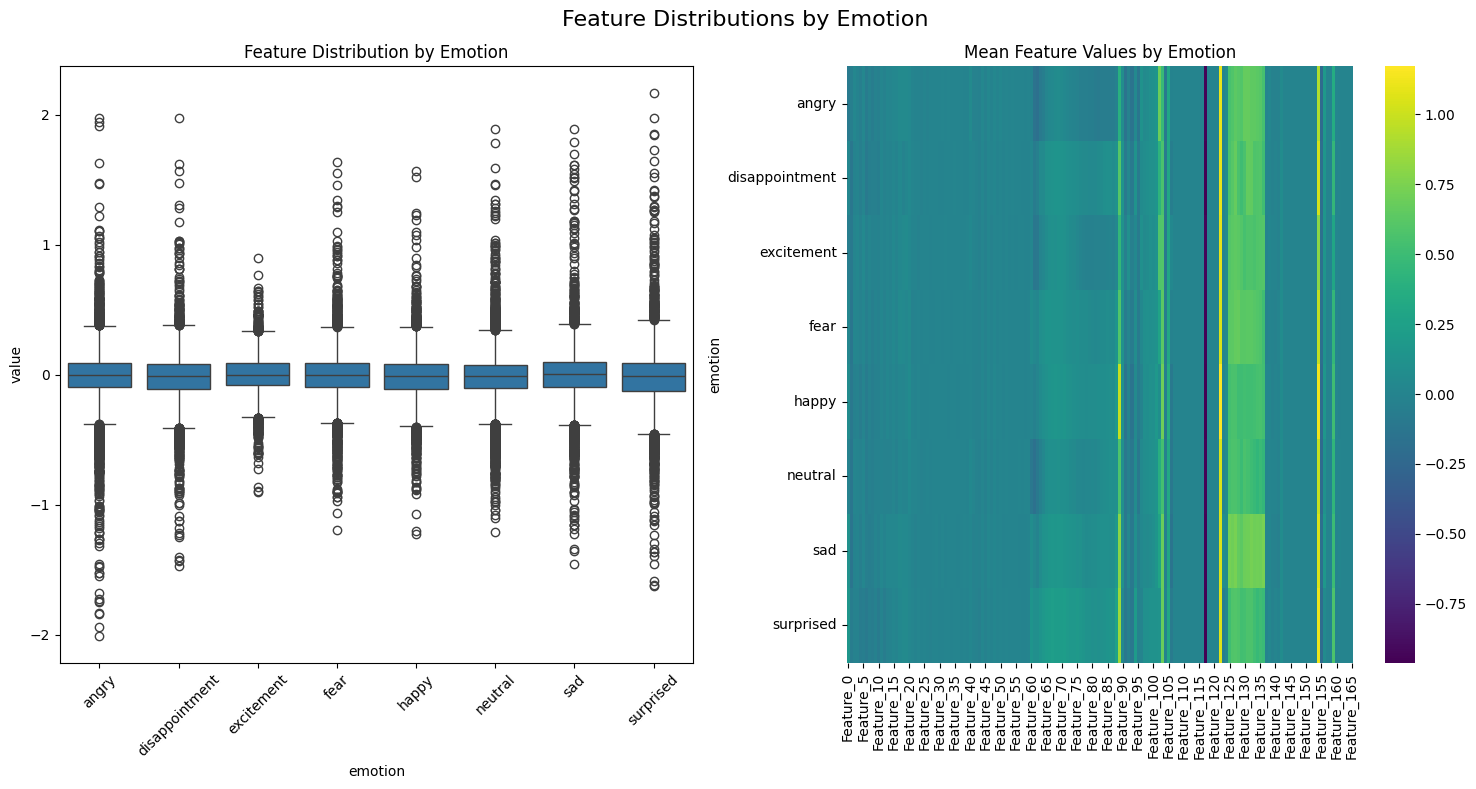


Top 10 Discriminative Features per Emotion:

NEUTRAL:
  Feature_134: 0.1503 (higher than average)
  Feature_60: 0.1480 (higher than average)
  Feature_61: 0.1345 (higher than average)
  Feature_133: 0.1265 (higher than average)
  Feature_132: 0.1190 (higher than average)
  Feature_135: 0.1142 (higher than average)
  Feature_136: 0.1055 (higher than average)
  Feature_131: 0.0905 (higher than average)
  Feature_129: 0.0818 (higher than average)
  Feature_127: 0.0786 (higher than average)

ANGRY:
  Feature_102: 0.3768 (higher than average)
  Feature_89: 0.2831 (higher than average)
  Feature_88: 0.1679 (higher than average)
  Feature_86: 0.1599 (higher than average)
  Feature_62: 0.1519 (higher than average)
  Feature_85: 0.1496 (higher than average)
  Feature_87: 0.1486 (higher than average)
  Feature_84: 0.1426 (higher than average)
  Feature_103: 0.1395 (higher than average)
  Feature_82: 0.1362 (higher than average)

SAD:
  Feature_136: 0.2225 (higher than average)
  Feature_89: 0.1

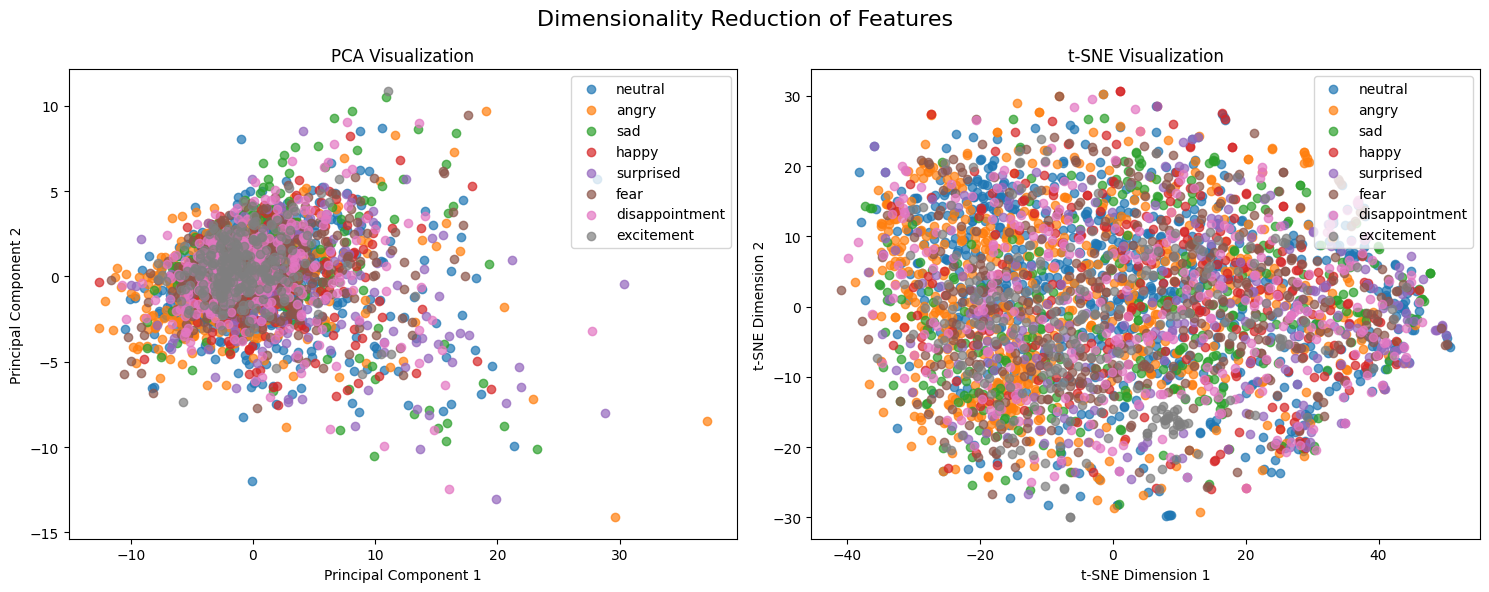

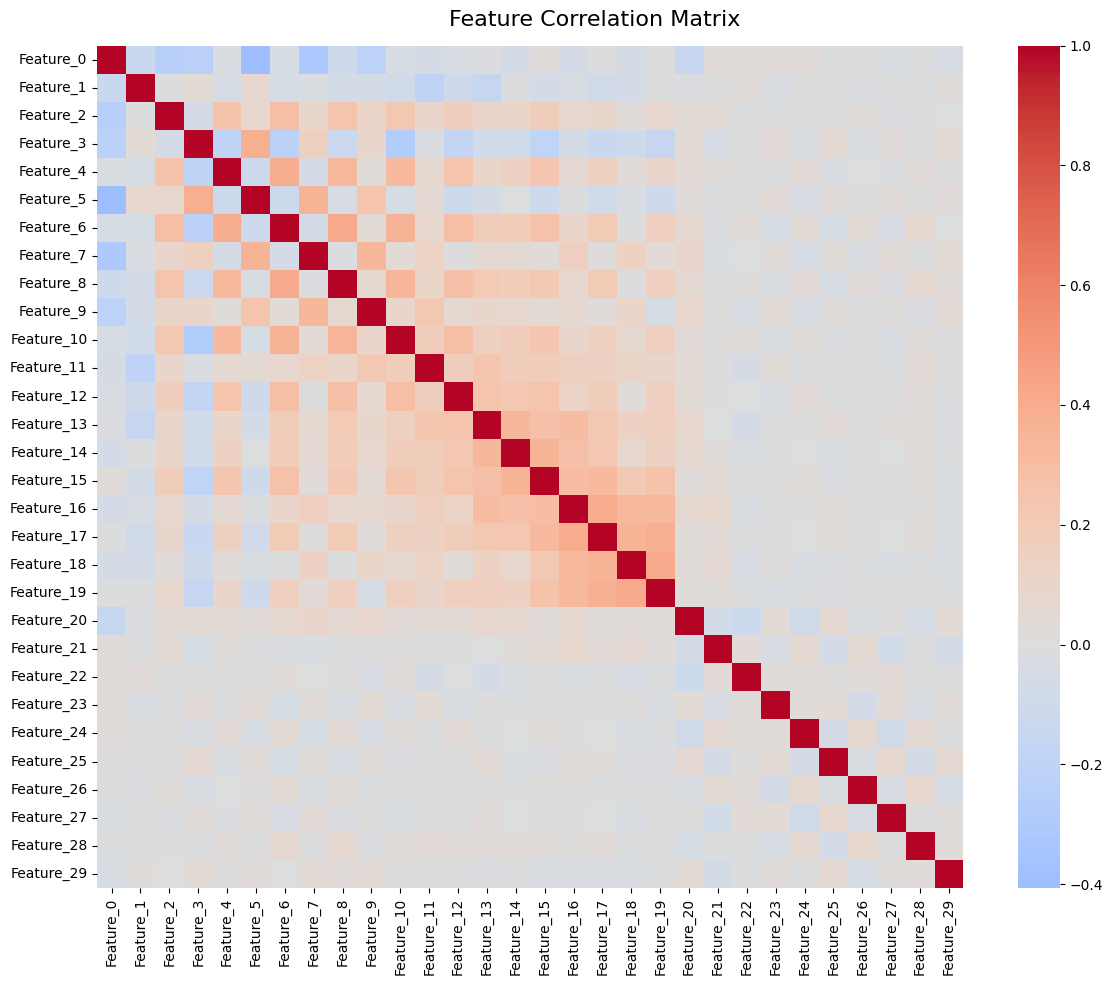


Analyzing Feature Groups:


<Figure size 1400x800 with 0 Axes>

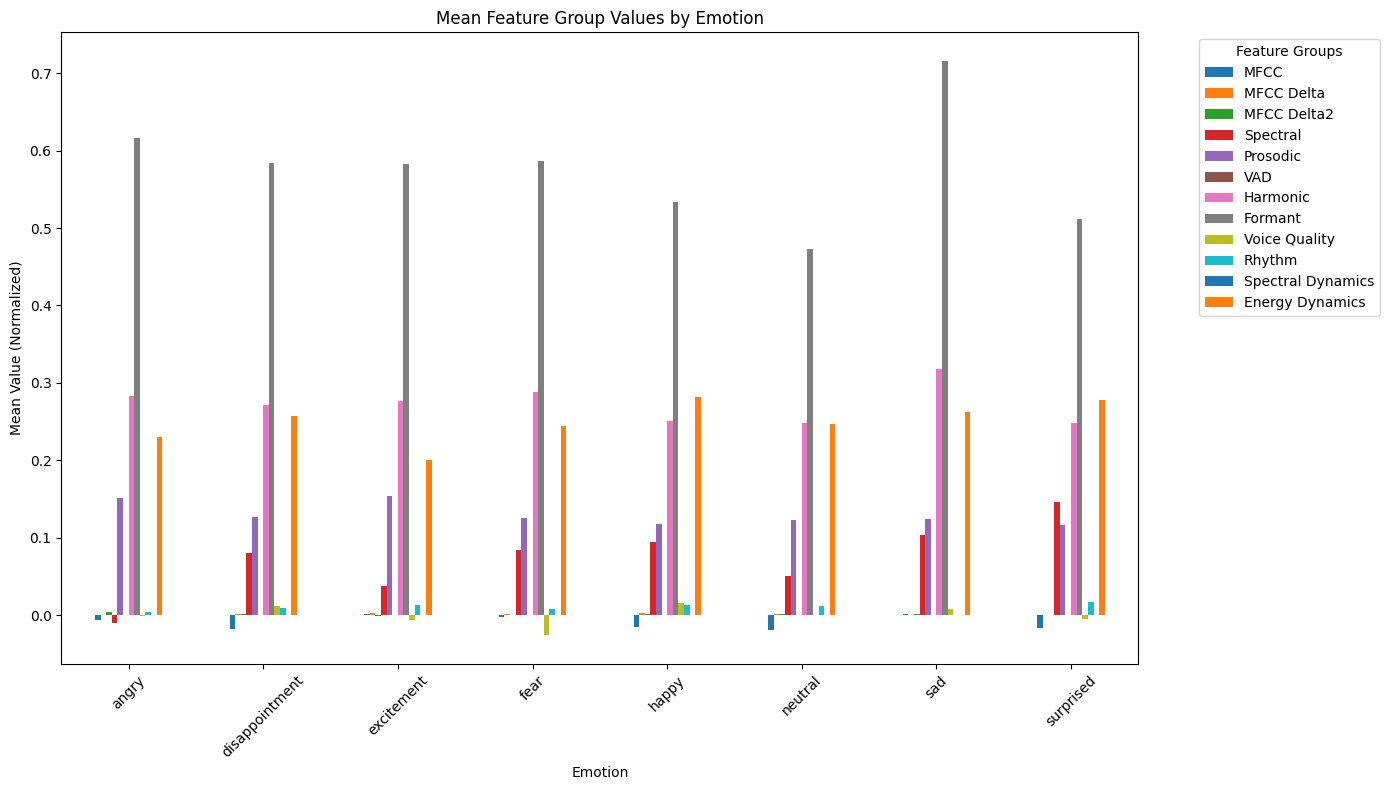


Most Discriminative Feature Groups per Emotion:

NEUTRAL:
  Formant: 0.1026 (higher than average)
  Harmonic: 0.0244 (higher than average)
  Spectral: 0.0226 (higher than average)

ANGRY:
  Spectral: 0.0837 (higher than average)
  Formant: 0.0405 (higher than average)
  Prosodic: 0.0213 (higher than average)

SAD:
  Formant: 0.1404 (higher than average)
  Harmonic: 0.0446 (higher than average)
  Spectral: 0.0297 (higher than average)

HAPPY:
  Formant: 0.0413 (higher than average)
  Energy Dynamics: 0.0318 (higher than average)
  Harmonic: 0.0223 (higher than average)

SURPRISED:
  Spectral: 0.0723 (higher than average)
  Formant: 0.0641 (higher than average)
  Energy Dynamics: 0.0277 (higher than average)

FEAR:
  Voice Quality: 0.0255 (higher than average)
  Harmonic: 0.0148 (higher than average)
  Formant: 0.0112 (higher than average)

DISAPPOINTMENT:
  Voice Quality: 0.0124 (higher than average)
  Formant: 0.0091 (higher than average)
  MFCC: 0.0087 (higher than average)

EXCITEME

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

def visualize_features_per_emotion(all_features, labels, label_map, n_features_to_show=20):
    """
    Visualize the comprehensive features per emotion using multiple visualization techniques
    
    Args:
        all_features: List of feature arrays (each of shape [155, n_frames])
        labels: List of emotion labels for each sample
        label_map: Dictionary mapping emotion names to indices
        n_features_to_show: Number of top features to show in detailed plots
    """
    # Convert labels to indices
    label_indices = [label_map[emotion.lower()] for emotion in labels]
    emotions = list(label_map.keys())
    
    # Aggregate features per sample (mean across frames)
    aggregated_features = []
    for feat in all_features:
        # Take mean across time frames for each feature
        sample_mean = np.mean(feat, axis=1)
        aggregated_features.append(sample_mean)
    
    aggregated_features = np.array(aggregated_features)  # Shape: [n_samples, 155]
    
    # Create a DataFrame for easier manipulation
    feature_names = [f"Feature_{i}" for i in range(aggregated_features.shape[1])]
    df = pd.DataFrame(aggregated_features, columns=feature_names)
    df['emotion'] = [emotions[idx] for idx in label_indices]
    
    # 1. Overall feature distribution per emotion (Boxplot)
    plt.figure(figsize=(15, 8))
    plt.suptitle('Feature Distributions by Emotion', fontsize=16)
    
    # Select a subset of features for visualization
    selected_features = feature_names[:n_features_to_show]
    
    # Melt dataframe for seaborn
    df_melt = pd.melt(df, id_vars=['emotion'], value_vars=selected_features, 
                      var_name='feature', value_name='value')
    
    # Create boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='emotion', y='value', data=df_melt)
    plt.title('Feature Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 2. Mean feature values per emotion (Heatmap)
    plt.subplot(1, 2, 2)
    emotion_means = df.groupby('emotion').mean()
    sns.heatmap(emotion_means, cmap='viridis')
    plt.title('Mean Feature Values by Emotion')
    plt.tight_layout()
    
    plt.show()
    
    # 3. Top discriminative features per emotion
    print("\nTop 10 Discriminative Features per Emotion:")
    print("=" * 60)
    
    for emotion in emotions:
        # Get samples for this emotion
        emotion_data = df[df['emotion'] == emotion].drop('emotion', axis=1)
        other_data = df[df['emotion'] != emotion].drop('emotion', axis=1)
        
        # Calculate mean difference between this emotion and others
        emotion_mean = emotion_data.mean()
        other_mean = other_data.mean()
        mean_diff = emotion_mean - other_mean
        
        # Get top features with largest differences
        top_features = mean_diff.abs().sort_values(ascending=False).head(10)
        
        print(f"\n{emotion.upper()}:")
        for feature, diff in top_features.items():
            direction = "higher" if diff > 0 else "lower"
            print(f"  {feature}: {diff:.4f} ({direction} than average)")
    
    # 4. Dimensionality reduction visualization
    print("\nGenerating dimensionality reduction plots...")
    
    # Standardize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(aggregated_features)
    
    # PCA visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(15, 6))
    plt.suptitle('Dimensionality Reduction of Features', fontsize=16)
    
    plt.subplot(1, 2, 1)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(features_scaled)
    
    plt.subplot(1, 2, 2)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. Feature correlation heatmap
    plt.figure(figsize=(12, 10))
    plt.suptitle('Feature Correlation Matrix', fontsize=16)
    
    # Calculate correlation matrix for a subset of features
    corr_features = feature_names[:30]  # First 30 features
    corr_matrix = df[corr_features].corr()
    
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.tight_layout()
    plt.show()
    
    # 6. Feature group analysis
    print("\nAnalyzing Feature Groups:")
    print("=" * 60)
    
    # Define feature groups based on your extraction function
    feature_groups = {
        'MFCC': list(range(0, 20)),  # First 20 features: MFCCs
        'MFCC Delta': list(range(20, 40)),  # Next 20: MFCC deltas
        'MFCC Delta2': list(range(40, 60)),  # Next 20: MFCC delta2
        'Spectral': list(range(60, 101)),  # Spectral features (41 features)
        'Prosodic': list(range(101, 111)),  # Prosodic features (10 features)
        'VAD': list(range(111, 116)),  # VAD features (5 features)
        'Harmonic': list(range(116, 132)),  # Harmonic features (16 features)
        'Formant': list(range(132, 137)),  # Formant features (5 features)
        'Voice Quality': [137],  # HNR feature
        'Rhythm': list(range(138, 143)),  # Rhythm features (5 features)
        'Spectral Dynamics': list(range(143, 151)),  # Spectral dynamics (8 features)
        'Energy Dynamics': list(range(151, 155))  # Energy dynamics (4 features)
    }
    
    # Calculate mean value per group per emotion
    group_means = {}
    for group, indices in feature_groups.items():
        group_features = [feature_names[i] for i in indices if i < len(feature_names)]
        if group_features:
            group_data = df.groupby('emotion')[group_features].mean()
            group_means[group] = group_data.mean(axis=1)  # Mean across features in the group
    
    # Convert to DataFrame for easier plotting
    group_df = pd.DataFrame(group_means)
    
    # Plot feature group means
    plt.figure(figsize=(14, 8))
    group_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Mean Feature Group Values by Emotion')
    plt.ylabel('Mean Value (Normalized)')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print most discriminative feature groups per emotion
    print("\nMost Discriminative Feature Groups per Emotion:")
    for emotion in emotions:
        emotion_values = group_df.loc[emotion]
        overall_mean = group_df.mean()
        diff = emotion_values - overall_mean
        top_groups = diff.abs().sort_values(ascending=False).head(3)
        
        print(f"\n{emotion.upper()}:")
        for group, diff_val in top_groups.items():
            direction = "higher" if diff_val > 0 else "lower"
            print(f"  {group}: {diff_val:.4f} ({direction} than average)")

# After extracting features and creating label_map, call the visualization function
print("\nVisualizing features per emotion...")
visualize_features_per_emotion(all_features, augmented_labels, label_map, n_features_to_show=20)

In [34]:
dataset = SUBESCODataset(all_features, augmented_labels, label_map)
print(f"Total dataset size: {len(dataset)}")

# Step 5: Split dataset
numerical_labels = [label_map[label] for label in augmented_labels]

# Train(70%) / Val(15%) / Test(15%) split
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss1.split(np.zeros(len(dataset)), numerical_labels))

train_val_labels = [numerical_labels[i] for i in train_val_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 15/85
train_idx, val_idx = next(sss2.split(np.zeros(len(train_val_idx)), train_val_labels))

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)  
test_dataset = torch.utils.data.Subset(dataset, test_idx)

print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Step 6: Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
                            num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=True)

Total dataset size: 3220
Dataset splits - Train: 1932, Val: 644, Test: 644


In [35]:
import torch
import torch.nn as nn
import math

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class AttentionPooling(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        scores = self.attn(x).squeeze(-1)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        pooled = torch.sum(weights * x, dim=1)
        return pooled

class FullComprehensiveModel(nn.Module):
    def __init__(self, 
                 input_features=166, 
                 num_classes=8, 
                 dropout_rate=0.4,
                 transf_heads=12,
                 transf_layers=3,
                 transf_ffw=1024,  # can set 768 or 2048
                 transf_dropout=0.2,
                 ):
        super().__init__()
        # --- Residual CNN trunk (replace original sequential CNN) ---
        self.cnn = nn.Sequential(
            ResidualBlock(input_features, 128, kernel_size=7, padding=3, dropout=0.2),
            nn.MaxPool1d(2),  # Reduce length
            ResidualBlock(128, 256, kernel_size=5, padding=2, dropout=0.3),
            nn.MaxPool1d(2),
            ResidualBlock(256, 384, kernel_size=3, padding=1, dropout=dropout_rate),
            nn.AdaptiveMaxPool1d(32)  # (B, 384, 32)
        )
        # --- Positional encoding for Transformer ---
        self.pos_encoding = PositionalEncoding(d_model=384, max_len=500)
        # --- Transformer block ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=384,
            nhead=transf_heads,
            dim_feedforward=transf_ffw,
            dropout=transf_dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transf_layers)
        # --- Attention pooling ---
        self.attn_pool = AttentionPooling(input_dim=384)
        # --- Deep classifier ---
        self.feature_fusion = nn.Sequential(
            nn.LayerNorm(384),
            nn.Linear(384, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (batch, features, frames)
        x = self.cnn(x)  # (batch, 384, 32)
        x = x.permute(0, 2, 1)  # (batch, 32, 384)
        x = self.pos_encoding(x)  # (batch, 32, 384)
        x = self.transformer(x)   # (batch, 32, 384)
        x = self.attn_pool(x)     # (batch, 384)
        x = self.feature_fusion(x)  # (batch, 1024)
        return self.classifier(x)   # (batch, num_classes)


Initializing real-time optimized model...
Starting training...
🎯 Training with LR: 0.000040
📊 Gap monitoring threshold: 0.12
Epoch  1/200 | Train: 0.238 | Val: 0.266 | Gap: 0.027 | Loss: 1.7618 | Time: 2.0s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.2655
Epoch  2/200 | Train: 0.254 | Val: 0.287 | Gap: 0.033 | Loss: 1.7571 | Time: 2.0s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.2873
Epoch  3/200 | Train: 0.254 | Val: 0.293 | Gap: 0.039 | Loss: 1.7344 | Time: 1.8s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.2935
Epoch  4/200 | Train: 0.293 | Val: 0.318 | Gap: 0.025 | Loss: 1.7432 | Time: 1.9s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.3183
Epoch  5/200 | Train: 0.295 | Val: 0.345 | Gap: 0.050 | Loss: 1.7080 | Time: 1.9s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.3447
Epoch  6/200 | Train: 0.341 | Val: 0.374 | Gap: 0.034 | Loss: 1.6693 | Time: 1.8s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.3742
Epoch  7/20

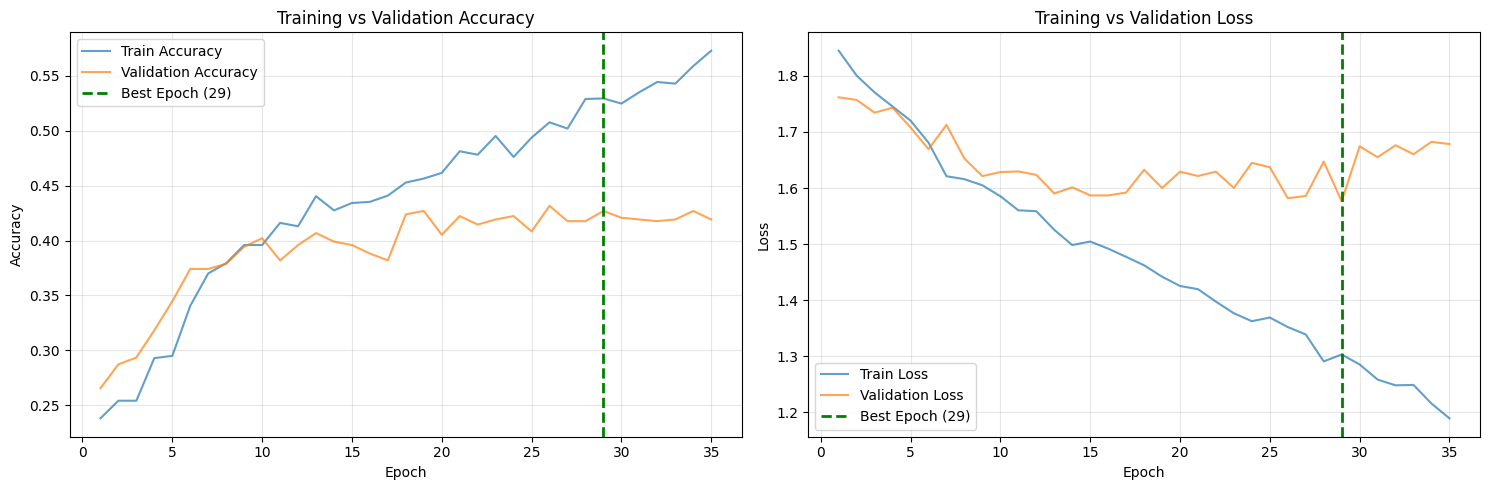

Best epoch: 29
Best validation loss: 1.5763
Best validation accuracy: 0.4270
Training completed! Best validation accuracy: 0.4317
Final evaluation...
Evaluating model...
Test Accuracy: 0.4674

Classification Report:
                precision    recall  f1-score   support

       neutral       0.53      0.84      0.65       137
         angry       0.50      0.87      0.63       124
           sad       0.00      0.00      0.00        67
         happy       0.28      0.51      0.36        59
     surprised       0.00      0.00      0.00        55
          fear       0.40      0.07      0.12        86
disappointment       0.00      0.00      0.00        65
    excitement       0.49      0.82      0.62        51

      accuracy                           0.47       644
     macro avg       0.27      0.39      0.30       644
  weighted avg       0.33      0.47      0.36       644



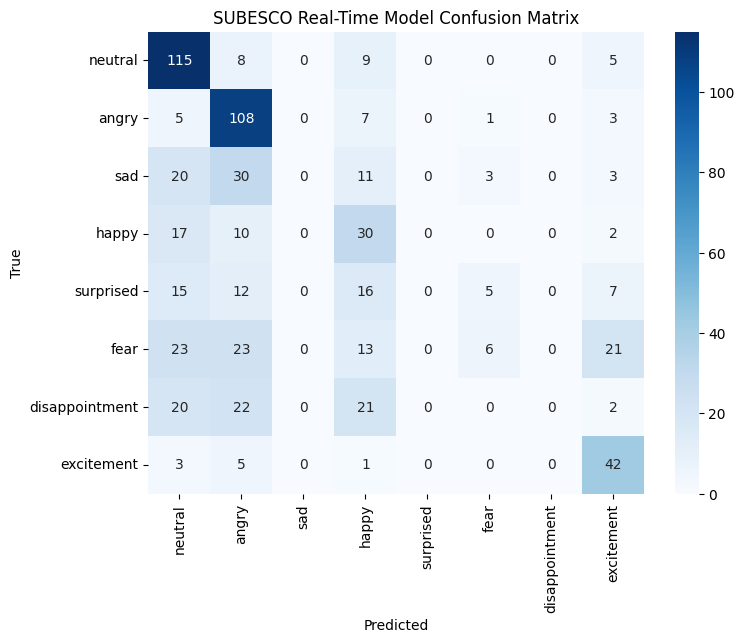


TRAINING COMPLETED!
Final Test Accuracy: 0.4674
Model saved as: SUBESCO_Realtime_Model.pth
Model parameters: 7,001,227


In [47]:
# Step 7: Initialize and train model
#gap control, comprehensive = 49
#best config, conprehensive 3 = 46
#gap control, realtime = 36
#gap control, classaware = 46
#gap control, highcapacity = 42
#gap control, multiscale = 45
#gap control, Lightweightmulti = 41
#gap control, Enhanced166 = 39
#gap control, Gapcontrolled = 38
#gap control, Ultraenhanced = 38
input_features = all_features[0].shape[0]  # E.g., 166
hidden_dim = 256   # You may tune this
num_classes = config.NUM_CLASSES
for i in range(1):
    print("Initializing real-time optimized model...")
    # model = RealtimeCNNTransformer(num_classes=config.NUM_CLASSES)
    model = MultiScaleCNNTransformer(num_classes=num_classes)

    print("Starting training...")
    model = train_best_known_config(model, train_loader, val_loader, num_epochs=200)

    # Step 8: Evaluate model
    print("Final evaluation...")
    test_accuracy = evaluate_realtime_model(model, test_loader, label_map_inv)

print(f"\n" + "=" * 60)
print(f"TRAINING COMPLETED!")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: SUBESCO_Realtime_Model.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 60)

In [177]:
import pickle
import os
from datetime import datetime
from pathlib import Path

def save_datasets_separately():
    """Save SUBESCO, KBES, and BanglaMOOD in separate cache folders"""
    
    try:
        # Create separate cache directories
        base_cache_dir = Path("augmented_dataset_cache")
        base_cache_dir.mkdir(exist_ok=True)
        
        subesco_dir = base_cache_dir / "SUBESCO"
        kbes_dir = base_cache_dir / "KBES" 
        banglamood_dir = base_cache_dir / "BanglaMOOD"
        
        for dir_path in [subesco_dir, kbes_dir, banglamood_dir]:
            dir_path.mkdir(exist_ok=True)
        
        print("🗂️  Creating separate dataset caches...")
        print("=" * 50)
        
        # Check if required variables exist
        required_vars = ['augmented_paths', 'augmented_labels', 'all_features']
        for var in required_vars:
            if var not in globals():
                print(f"❌ Required variable '{var}' not found in memory!")
                return None
        
        # Get data from memory
        original_paths = globals()['augmented_paths']
        original_labels = globals()['augmented_labels']
        original_features = globals()['all_features']
        
        # Separate data by dataset
        subesco_data = {'paths': [], 'labels': [], 'features': []}
        kbes_data = {'paths': [], 'labels': [], 'features': []}
        banglamood_data = {'paths': [], 'labels': [], 'features': []}
        
        # Sort data into datasets
        for i, (path, label, feature) in enumerate(zip(original_paths, original_labels, original_features)):
            path_str = str(path).lower()
            
            if 'subesco' in path_str:
                subesco_data['paths'].append(path)
                subesco_data['labels'].append(label)
                subesco_data['features'].append(feature)
                
            elif 'kbes' in path_str or 'kuet' in path_str:
                kbes_data['paths'].append(path)
                kbes_data['labels'].append(label)
                kbes_data['features'].append(feature)
                
            elif 'banglamood' in path_str or 'mood' in path_str:
                banglamood_data['paths'].append(path)
                banglamood_data['labels'].append(label)
                banglamood_data['features'].append(feature)
        
        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save each dataset separately
        saved_caches = {}
        
        for dataset_name, data, cache_dir in [
            ('SUBESCO', subesco_data, subesco_dir),
            ('KBES', kbes_data, kbes_dir),
            ('BanglaMOOD', banglamood_data, banglamood_dir)
        ]:
            
            if len(data['features']) > 0:
                # Count emotions in this dataset
                emotion_counts = {}
                for label in data['labels']:
                    label_str = str(label).lower()
                    if label_str not in emotion_counts:
                        emotion_counts[label_str] = 0
                    emotion_counts[label_str] += 1
                
                # Prepare save data
                save_data = {
                    'all_features': data['features'],
                    'augmented_labels': data['labels'],
                    'augmented_paths': data['paths'],
                    'dataset_name': dataset_name,
                    'save_timestamp': datetime.now().isoformat(),
                    'total_samples': len(data['features']),
                    'emotion_counts': emotion_counts,
                    'feature_shape': data['features'][0].shape if data['features'] else None
                }
                
                # Add label mappings if they exist
                if 'label_map' in globals():
                    save_data['label_map'] = globals()['label_map']
                if 'label_map_inv' in globals():
                    save_data['label_map_inv'] = globals()['label_map_inv']
                
                # Save to file
                cache_file = cache_dir / f"{dataset_name}_{timestamp}.pkl"
                with open(cache_file, 'wb') as f:
                    pickle.dump(save_data, f, protocol=pickle.HIGHEST_PROTOCOL)
                
                file_size_mb = os.path.getsize(cache_file) / (1024**2)
                saved_caches[dataset_name] = str(cache_file)
                
                print(f"✅ {dataset_name} Dataset Saved:")
                print(f"   📁 Path: {cache_file}")
                print(f"   💾 Size: {file_size_mb:.1f} MB")
                print(f"   📊 Samples: {len(data['features'])}")
                print(f"   🎭 Emotions: {', '.join(emotion_counts.keys())}")
                print()
                
            else:
                print(f"⚠️  {dataset_name}: No data found to save")
                print()
        
        print("🎉 ALL DATASETS SAVED SEPARATELY!")
        print(f"📂 Cache location: {base_cache_dir}")
        print(f"🗂️  Folders created: SUBESCO, KBES, BanglaMOOD")
        
        return saved_caches
        
    except Exception as e:
        print(f"❌ SEPARATE SAVE FAILED: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the separate saves
saved_cache_info = save_datasets_separately()


🗂️  Creating separate dataset caches...
⚠️  SUBESCO: No data found to save

✅ KBES Dataset Saved:
   📁 Path: augmented_dataset_cache\KBES\KBES_20250730_021859.pkl
   💾 Size: 69.1 MB
   📊 Samples: 436
   🎭 Emotions: neutral, angry, disappointment, happy, sad

✅ BanglaMOOD Dataset Saved:
   📁 Path: augmented_dataset_cache\BanglaMOOD\BanglaMOOD_20250730_021859.pkl
   💾 Size: 254.2 MB
   📊 Samples: 1605
   🎭 Emotions: neutral, angry, disappointment, fear, happy, sad, surprised, excitement

🎉 ALL DATASETS SAVED SEPARATELY!
📂 Cache location: augmented_dataset_cache
🗂️  Folders created: SUBESCO, KBES, BanglaMOOD


In [ ]:
# def verify_excitement_filtered_save():
#     """Verify the filtered save worked correctly"""
    
#     print("🔍 VERIFYING FILTERED DATASET (SUBESCO + KBES + Excitement):")
#     print("-" * 60)
    
#     # Check current data in memory
#     if 'augmented_paths' in globals() and 'augmented_labels' in globals():
#         paths = globals()['augmented_paths']
#         labels = globals()['augmented_labels']
        
#         # Count by dataset
#         total = len(paths)
#         subesco = 0
#         kbes = 0
#         banglamood_excitement = 0
#         banglamood_other = 0
        
#         emotion_breakdown = {}
        
#         for path, label in zip(paths, labels):
#             path_str = str(path).lower()
#             label_str = str(label).lower()
            
#             # Count by dataset
#             if 'subesco' in path_str:
#                 subesco += 1
#             elif 'kbes' in path_str or 'kuet' in path_str:
#                 kbes += 1
#             elif 'banglamood' in path_str or 'mood' in path_str:
#                 if 'excitement' in label_str or 'excited' in label_str:
#                     banglamood_excitement += 1
#                 else:
#                     banglamood_other += 1
            
#             # Count emotions
#             if label_str not in emotion_breakdown:
#                 emotion_breakdown[label_str] = 0
#             emotion_breakdown[label_str] += 1
        
#         print(f"📊 Current Memory Contents:")
#         print(f"   Total samples: {total}")
#         print(f"   SUBESCO: {subesco}")
#         print(f"   KBES: {kbes}")
#         print(f"   BanglaMOOD Excitement: {banglamood_excitement}")
#         print(f"   BanglaMOOD Other: {banglamood_other}")
        
#         print(f"\n🎭 Emotion Breakdown:")
#         for emotion, count in sorted(emotion_breakdown.items()):
#             print(f"   {emotion.capitalize()}: {count}")
        
#         if banglamood_other > 0:
#             print(f"\n⚠️  Note: {banglamood_other} non-excitement BanglaMOOD samples still in memory")
#             print(f"   The saved cache excludes them, but memory contains all data")
#         else:
#             print(f"\n✅ Current memory already filtered correctly")
            
#         # Show sample excitement files
#         excitement_paths = [p for p, l in zip(paths, labels) 
#                           if 'excitement' in str(l).lower() or 'excited' in str(l).lower()]
        
#         if excitement_paths:
#             print(f"\n🎊 Sample Excitement files:")
#             for i, path in enumerate(excitement_paths[:3]):  # Show first 3
#                 path_name = os.path.basename(str(path))
#                 dataset = "BanglaMOOD" if any(x in str(path).lower() for x in ['banglamood', 'mood']) else "Other"
#                 print(f"   {path_name} ({dataset})")
#             if len(excitement_paths) > 3:
#                 print(f"   ... and {len(excitement_paths) - 3} more excitement samples")
    
#     else:
#         print("❌ No path/label data found in current memory")

# # Run verification
# verify_excitement_filtered_save()


🔍 VERIFYING FILTERED DATASET (SUBESCO + KBES + Excitement):
------------------------------------------------------------
📊 Current Memory Contents:
   Total samples: 11120
   SUBESCO: 7000
   KBES: 900
   BanglaMOOD Excitement: 257
   BanglaMOOD Other: 2963

🎭 Emotion Breakdown:
   Angry: 1821
   Disappointment: 1526
   Excitement: 257
   Fear: 1430
   Happy: 1494
   Neutral: 1785
   Sad: 1534
   Surprised: 1273

⚠️  Note: 2963 non-excitement BanglaMOOD samples still in memory
   The saved cache excludes them, but memory contains all data

🎊 Sample Excitement files:
   0042.wav (BanglaMOOD)
   0115.wav (BanglaMOOD)
   0116.wav (BanglaMOOD)
   ... and 254 more excitement samples


In [169]:
import torch
import os
import numpy as np
from sklearn.metrics import classification_report
import librosa
import soundfile as sf

def load_trained_model(model_path="SUBESCO_Realtime_Model.pth"):
    """Load the trained model"""
    model = BasicCNNEmotion(166,num_classes=8)
    model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
    model.to(config.DEVICE)
    model.eval()
    print(f"✅ Model loaded from {model_path}")
    return model

def test_audio_files(model, test_folder_path, show_details=True):
    """Test model on audio files in a folder"""
    
    # Emotion labels (adjust order to match your training)
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'excitement', 'disappointment']
    
    print(f"🎵 Testing audio files in: {test_folder_path}")
    print("=" * 60)
    
    results = []
    
    # Get all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []
    
    for file in os.listdir(test_folder_path):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            audio_files.append(file)
    
    if not audio_files:
        print("❌ No audio files found in the specified folder!")
        return
    
    print(f"Found {len(audio_files)} audio files to test\n")
    
    with torch.no_grad():
        for i, filename in enumerate(audio_files, 1):
            file_path = os.path.join(test_folder_path, filename)
            
            try:
                # Extract features using your enhanced feature extraction
                features = extract_comprehensive_noise_robust_features(file_path)  # Returns (80, n_frames)
                
                # Convert to tensor and add batch dimension
                features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)  # (1, 80, n_frames)
                
                # Make prediction
                outputs = model(features_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(outputs, dim=1).item()
                confidence = probabilities[0][predicted_class].item()
                
                predicted_emotion = emotion_labels[predicted_class]
                
                # Store results
                result = {
                    'filename': filename,
                    'predicted_emotion': predicted_emotion,
                    'confidence': confidence,
                    'all_probabilities': probabilities[0].cpu().numpy()
                }
                results.append(result)
                
                # Print results
                if show_details:
                    print(f"{i:2d}. {filename}")
                    print(f"    🎯 Predicted: {predicted_emotion.upper()} ({confidence:.3f})")
                    
                    # Show top 3 predictions
                    top3_indices = torch.topk(probabilities[0], 3).indices.cpu().numpy()
                    print("    📊 Top 3 predictions:")
                    for j, idx in enumerate(top3_indices):
                        emotion = emotion_labels[idx]
                        prob = probabilities[0][idx].item()
                        print(f"       {j+1}. {emotion}: {prob:.3f}")
                    print()
                else:
                    print(f"{i:2d}. {filename:<30} → {predicted_emotion.upper()} ({confidence:.3f})")
                    
            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    
    return results

def test_single_audio(model, audio_path):
    """Test a single audio file"""
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'excitement', 'disappointment']
    
    print(f"🎵 Testing single file: {os.path.basename(audio_path)}")
    print("=" * 50)
    
    try:
        # Extract features
        features = extract_ultra_enhanced_emotion_features(audio_path)
        features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)
        
        with torch.no_grad():
            outputs = model(features_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            
            predicted_emotion = emotion_labels[predicted_class]
            
            print(f"🎯 Predicted Emotion: {predicted_emotion.upper()}")
            print(f"📈 Confidence: {confidence:.3f}")
            print("\n📊 All Emotion Probabilities:")
            
            # Sort by probability
            sorted_indices = torch.argsort(probabilities[0], descending=True).cpu().numpy()
            
            for i, idx in enumerate(sorted_indices):
                emotion = emotion_labels[idx]
                prob = probabilities[0][idx].item()
                bar = "█" * int(prob * 20)  # Simple bar chart
                print(f"   {emotion:<12}: {prob:.3f} {bar}")
                
        return predicted_emotion, confidence
        
    except Exception as e:
        print(f"❌ Error processing file: {e}")
        return None, None

def batch_test_with_summary(model, test_folder_path):
    """Test folder and provide summary statistics"""
    results = test_audio_files(model, test_folder_path, show_details=False)
    
    if not results:
        return
    
    print(f"\n📈 TESTING SUMMARY")
    print("=" * 40)
    
    # Count predictions by emotion
    emotion_counts = {}
    confidence_by_emotion = {}
    
    for result in results:
        emotion = result['predicted_emotion']
        confidence = result['confidence']
        
        if emotion not in emotion_counts:
            emotion_counts[emotion] = 0
            confidence_by_emotion[emotion] = []
        
        emotion_counts[emotion] += 1
        confidence_by_emotion[emotion].append(confidence)
    
    # Print summary
    total_files = len(results)
    print(f"Total files tested: {total_files}")
    print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")
    print("\nEmotion Distribution:")
    
    for emotion, count in sorted(emotion_counts.items()):
        percentage = (count / total_files) * 100
        avg_confidence = np.mean(confidence_by_emotion[emotion])
        print(f"  {emotion:<12}: {count:2d} files ({percentage:4.1f}%) - Avg confidence: {avg_confidence:.3f}")
    
    # Find high and low confidence predictions
    high_confidence = [r for r in results if r['confidence'] > 0.8]
    low_confidence = [r for r in results if r['confidence'] < 0.5]
    
    print(f"\nHigh confidence predictions (>0.8): {len(high_confidence)}")
    print(f"Low confidence predictions (<0.5): {len(low_confidence)}")
    
    if low_confidence:
        print("\n⚠️  Low confidence files:")
        for result in low_confidence:
            print(f"   {result['filename']}: {result['predicted_emotion']} ({result['confidence']:.3f})")


"""Main testing interface"""
print("🤖 Emotion Recognition Model Tester")
print("=" * 60)

# Load model
model = load_trained_model("SUBESCO_Realtime_Model.pth")

test_audio_files(model, "C:\\Users\\guyaw\\Desktop\\CSE499 Research papers\\Jupiter\\7-Emotion-Bangla-Speech-Recognition-Model\\Testing", show_details=True)


🤖 Emotion Recognition Model Tester
✅ Model loaded from SUBESCO_Realtime_Model.pth
🎵 Testing audio files in: C:\Users\guyaw\Desktop\CSE499 Research papers\Jupiter\7-Emotion-Bangla-Speech-Recognition-Model\Testing
Found 13 audio files to test

 1. 1-1-1-023 Neutral.wav
    🎯 Predicted: HAPPY (0.305)
    📊 Top 3 predictions:
       1. happy: 0.305
       2. surprised: 0.151
       3. neutral: 0.136

 2. 2-2-0-014 happy.wav
    🎯 Predicted: FEAR (0.348)
    📊 Top 3 predictions:
       1. fear: 0.348
       2. sad: 0.218
       3. happy: 0.133

 3. 3-1-1-021 sad.wav
    🎯 Predicted: SAD (0.424)
    📊 Top 3 predictions:
       1. sad: 0.424
       2. neutral: 0.148
       3. surprised: 0.133

 4. 4-2-0-011angry.wav
    🎯 Predicted: SAD (0.269)
    📊 Top 3 predictions:
       1. sad: 0.269
       2. angry: 0.206
       3. excitement: 0.186

 5. 5-2-0-007 disappoint.wav
    🎯 Predicted: ANGRY (0.332)
    📊 Top 3 predictions:
       1. angry: 0.332
       2. excitement: 0.298
       3. neutral:

[{'filename': '1-1-1-023 Neutral.wav',
  'predicted_emotion': 'happy',
  'confidence': 0.3045156002044678,
  'all_probabilities': array([0.1360142 , 0.05769534, 0.06844742, 0.3045156 , 0.15069784,
         0.0844562 , 0.12113748, 0.0770359 ], dtype=float32)},
 {'filename': '2-2-0-014 happy.wav',
  'predicted_emotion': 'fear',
  'confidence': 0.34838175773620605,
  'all_probabilities': array([0.05913943, 0.05962342, 0.21822737, 0.13339134, 0.0466109 ,
         0.34838176, 0.08059289, 0.05403285], dtype=float32)},
 {'filename': '3-1-1-021 sad.wav',
  'predicted_emotion': 'sad',
  'confidence': 0.4239124357700348,
  'all_probabilities': array([0.14849009, 0.05452334, 0.42391244, 0.025736  , 0.1331599 ,
         0.05800702, 0.0821885 , 0.07398276], dtype=float32)},
 {'filename': '4-2-0-011angry.wav',
  'predicted_emotion': 'sad',
  'confidence': 0.2687140107154846,
  'all_probabilities': array([0.05461243, 0.20588426, 0.268714  , 0.07925467, 0.02382439,
         0.12003358, 0.18553168, 0.0